# Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm
import powerlaw
import random

from collections import defaultdict
import scipy.stats as stats

import itertools



# Top-line Variables + Settings

In [78]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

PLOTS_PATH = Path("./writing/images/")
TABLES_PATH = Path("./writing/tables/")

# Loading in  ICIJ

In [2]:
icij_data_path = Path("datasets/ICIJ/data")

addresses_path = icij_data_path / "nodes-addresses.csv"
officers_path = icij_data_path / "nodes-officers.csv"
entities_path = icij_data_path / "nodes-entities.csv"
intermediaries_path = icij_data_path / "nodes-intermediaries.csv"
others_path = icij_data_path / "nodes-others.csv"
relationships_path = icij_data_path / "relationships.csv"

officers_df = pd.read_csv(officers_path)
entities_df = pd.read_csv(entities_path)
intermediaries_df = pd.read_csv(intermediaries_path)
others_df = pd.read_csv(others_path)
relationships_df = pd.read_csv(relationships_path)
addresses_df = pd.read_csv(addresses_path)

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/2965263412.py:11: DtypeWarning: Columns (2,3,6,7,10,11,12,13,14,15,16,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  entities_df = pd.read_csv(entities_path)
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/2965263412.py:14: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  relationships_df = pd.read_csv(relationships_path)


# Exploratory, each major dataset


1. Clarifying "country" vs. "jurisidction" for entities:
2. Clarifying different "entity_types"
3. Time Series of entities_df and incorporation dates of them


Jurisdiction is the country under whose laws entity is incorporated and governed, 

Country instead: The nation-state associated with an address, officer, or activity of the entity

In [3]:
officers_df.head()

,node_id,name,countries,country_codes,sourceID,valid_until,note
0,12000001,KIM SOO IN,South Korea,KOR,Panama Papers,The Panama Papers data is current through 2015,NaN
1,12000002,Tian Yuan,China,CHN,Panama Papers,The Panama Papers data is current through 2015,NaN
2,12000003,GREGORY JOHN SOLOMON,Australia,AUS,Panama Papers,The Panama Papers data is current through 2015,NaN
3,12000004,MATSUDA MASUMI,Japan,JPN,Panama Papers,The Panama Papers data is current through 2015,NaN
4,12000005,HO THUY NGA,Viet Nam,VNM,Panama Papers,The Panama Papers data is current through 2015,NaN


In [4]:
officers_df["name"].value_counts().head(20)

name
THE BEARER                                70873
EL PORTADOR                                9325
Bearer 1                                   2655
CARMICHAEL TREVOR A.                       1196
CLEMENTI LIMITED                           1111
TANAH MERAH LIMITED                        1046
BUKIT MERAH LIMITED                         963
CST ADMINISTRATION (BAHAM                   835
Bearer                                      818
The Bearer                                  813
THE CORPORATE SECRETARY LIMITED             700
Christopher Marcus GRADEL                   576
BEARER                                      537
COURT ADMINISTRATION LIMI                   474
PRIMARY MANAGEMENT LIMITE                   449
BARNES DEBORAH J.                           416
FIELDS JAMES A.                             408
BLUE SEAS ADMINISTRATION                    389
STANDARD NOMINEES (BAHAMA                   384
TRIDENT CORPORATE SERVICES (B'DOS) LTD      369
Name: count, dtype: int64

### Entities_df description

In [5]:
entities_df.head()

,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,inactivation_date,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,23-MAR-2006,18-FEB-2013,15-FEB-2013,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,27-MAR-2006,27-FEB-2014,15-FEB-2014,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,10-JAN-2006,15-FEB-2012,15-FEB-2012,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,06-JAN-2006,16-FEB-2009,15-FEB-2009,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,19-APR-2006,15-MAY-2009,15-FEB-2008,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN


In [6]:
entities_df["company_type"].value_counts().head(30)

company_type
Standard International Company                    40072
Standard Company under IBC Act                    26214
Business Company Limited by Shares                25130
Regular (Local) Company                           17599
Business Corporation                              16244
Client Sundry Account                              8692
International Trust                                 999
Cook Islands Asset Protection Trust                 547
Domestic Company                                    462
Cook Islands Asset Protection Trust - 3520A         445
International Company                               390
Sundry Account                                      292
Cook Islands Trust                                  253
International Business Corporation                  201
BVI Trust                                           162
The GRA group of Companies for express Co.          127
Nominee Only Entity                                 108
Mutual Fund Manager                

Entity Type	Description
| Entity Type | Description |
|-------------|-------------|
| Standard International Company | A generic offshore company formed under international business company (IBC) laws, typically used for asset holding, trade, or tax planning. |
| Standard Company under IBC Act | An offshore company set up specifically under an International Business Companies Act, common in jurisdictions like the British Virgin Islands (BVI) and Seychelles. Used for international business, often with tax and privacy benefits. |
| Business Company Limited by Shares | A company whose capital is divided into shares owned by shareholders. Liability is limited to the amount unpaid on shares. Common in many offshore jurisdictions. |
| Regular (Local) Company | A company incorporated to operate primarily within the local jurisdiction, as opposed to international business companies which are meant for overseas operations. |
| Business Corporation | A general term for a company formed to conduct business, often used interchangeably with "company" or "corporation." May be used in both local and offshore contexts. |
| Client Sundry Account | An account or entity used by intermediaries to hold or manage funds or assets on behalf of multiple clients, often for administrative or pooling purposes. |
| International Trust | A trust established under international trust laws, usually for asset protection, estate planning, or confidentiality. |
| Cook Islands Asset Protection Trust | A trust specifically formed in the Cook Islands, known for strong asset protection features and privacy. Used to shield assets from creditors or legal claims. |
| Domestic Company | A company incorporated and operating in its country of registration, as opposed to an offshore or international company. |
| Cook Islands Asset Protection Trust - 3520A | A variant of the Cook Islands Asset Protection Trust, possibly referencing a specific trust structure or compliance form (such as IRS Form 3520-A for U.S. taxpayers). |
| International Company | A broad term for a company registered in an offshore jurisdiction for the purpose of conducting international business. |
| Sundry Account | Similar to "Client Sundry Account," used to manage miscellaneous or pooled client funds/assets. |
| Cook Islands Trust | A trust registered in the Cook Islands, used for asset protection and privacy. |
| International Business Corporation | A specific type of offshore company, usually with tax and regulatory benefits, common in jurisdictions like BVI and Panama. |
| BVI Trust | A trust established in the British Virgin Islands, often used for estate planning, privacy, and asset protection. |
| The GRA group of Companies for express Co. | Likely refers to a group structure or holding company arrangement, possibly managed by a specific intermediary or service provider. |
| Nominee Only Entity | An entity where only nominee directors or shareholders are listed, obscuring the identity of the real (beneficial) owners. |
| Mutual Fund Manager | A company licensed to manage mutual funds, often set up offshore for regulatory or tax reasons. |
| Mutual Fund | An investment vehicle that pools money from multiple investors to invest in securities, sometimes established offshore for tax efficiency. |
| Foreign Company Transfer | Refers to the transfer or registration of a foreign company within the offshore jurisdiction, possibly as part of a re-domiciliation or restructuring. |


Note, we can easily join to addresses using address as well

In [7]:
for date_col in ["incorporation_date", "inactivation_date", "struck_off_date"]:
    entities_df[date_col] = pd.to_datetime(entities_df[date_col], format="%d-%b-%Y", errors="coerce")
    entities_df.loc[entities_df[date_col].dt.year > 2100, date_col] = pd.NaT
    print(f"Min date for {date_col}: {entities_df[date_col].min()}")
    print(f"Max date for {date_col}: {entities_df[date_col].max()}")

Min date for incorporation_date: 1865-10-26 00:00:00
Max date for incorporation_date: 2029-04-15 00:00:00
Min date for inactivation_date: 1930-11-30 00:00:00
Max date for inactivation_date: 2017-12-07 00:00:00
Min date for struck_off_date: 1919-02-02 00:00:00
Max date for struck_off_date: 2024-06-14 00:00:00


In [8]:
source_mapping = {
    'Panama Papers': 'Panama Papers',
    'Paradise Papers': 'Paradise Papers',
    'Paradise Papers - Malta corporate registry': 'Paradise Papers',
    'Paradise Papers - Nevis corporate registry': 'Paradise Papers',
    'Paradise Papers - Aruba corporate registry': 'Paradise Papers',
    'Paradise Papers - Barbados corporate registry': 'Paradise Papers',
    'Paradise Papers - Bahamas corporate registry': 'Paradise Papers',
    'Paradise Papers - Samoa corporate registry': 'Paradise Papers',
    'Paradise Papers - Cook Islands corporate registry': 'Paradise Papers',
    'Paradise Papers - Lebanon corporate registry': 'Paradise Papers',
    'Pandora Papers - Alemán, Cordero, Galindo & Lee (Alcogal)': 'Pandora Papers',
    'Pandora Papers - SFM Corporate Services': 'Pandora Papers',
    'Pandora Papers - Commence Overseas': 'Pandora Papers',
    'Pandora Papers - Alpha Consulting': 'Pandora Papers',
    'Pandora Papers - Fidelity Corporate Services': 'Pandora Papers',
    'Pandora Papers - Trident Trust': 'Pandora Papers',
    'Pandora Papers - CILTrust International': 'Pandora Papers',
    'Pandora Papers - Il Shin Corporate Consulting Limited': 'Pandora Papers',
    'Pandora Papers - Overseas Management Company (OMC)': 'Pandora Papers',
    'Pandora Papers - Asiaciti Trust': 'Pandora Papers',
    'Bahamas Leaks': 'Bahamas Leaks',
    'Offshore Leaks': 'Offshore Leaks'
}

entities_df['source'] = entities_df['sourceID'].map(source_mapping)

print(entities_df['source'].value_counts())

source
Paradise Papers    265150
Panama Papers      213634
Bahamas Leaks      175888
Offshore Leaks     105516
Pandora Papers      29220
Name: count, dtype: int64


# Enriching relationships_df

1. Getting the type of node on each side, `node_type_start` and `node_type_end`
2. Flipping usch that intermediaries are always node_starts

In [10]:
relationships_df.head()

,node_id_start,node_id_end,rel_type,link,status,start_date,end_date,sourceID
0,10000035,14095990,registered_address,registered address,NaN,NaN,NaN,Panama Papers
1,10000044,14091035,registered_address,registered address,NaN,NaN,NaN,Panama Papers
2,10000055,14095990,registered_address,registered address,NaN,NaN,NaN,Panama Papers
3,10000063,10007006,same_as,same name and registration date as,NaN,NaN,NaN,NaN
4,10000064,14091429,registered_address,registered address,NaN,NaN,NaN,Panama Papers


In [11]:
# Sets of node IDs for faster lookups
address_ids = set(addresses_df['node_id'])
entity_ids = set(entities_df['node_id'])
officer_ids = set(officers_df['node_id'])
intermediary_ids = set(intermediaries_df['node_id'])
other_ids = set(others_df['node_id']) 

def get_node_type(node_id):
    if node_id in entity_ids:
        return 'entity'
    elif node_id in officer_ids:
        return 'officer'
    elif node_id in intermediary_ids:
        return 'intermediary'
    elif node_id in address_ids:
        return 'address'
    elif node_id in other_ids:
        return 'other'
    else:
        return 'unknown' 

relationships_df['node_type_start'] = relationships_df['node_id_start'].map(get_node_type)
relationships_df['node_type_end'] = relationships_df['node_id_end'].map(get_node_type)

In [12]:
relationships_df["node_type_end"].value_counts()

node_type_end
entity          2353551
address          833064
officer          150024
other              2278
intermediary        350
Name: count, dtype: int64

A bidirectonial graph, so for convenience we transform all relations to always start with the intermediary for convenience. Only ones that will remain with intermediary as node_type_end are the relations between intermediaries themselves

In [13]:
rows_to_flip = (relationships_df['node_type_end'] == 'intermediary') 

# store original values for swapping
start_nodes_temp = relationships_df.loc[rows_to_flip, 'node_id_start'].copy()
start_types_temp = relationships_df.loc[rows_to_flip, 'node_type_start'].copy()

# perform the swap for node IDs
relationships_df.loc[rows_to_flip, 'node_id_start'] = relationships_df.loc[rows_to_flip, 'node_id_end']
relationships_df.loc[rows_to_flip, 'node_id_end'] = start_nodes_temp

# perform the swap for node types
relationships_df.loc[rows_to_flip, 'node_type_start'] = relationships_df.loc[rows_to_flip, 'node_type_end']
relationships_df.loc[rows_to_flip, 'node_type_end'] = start_types_temp

relationships_df["node_type_end"].value_counts()

node_type_end
entity          2353551
address          833064
officer          150330
other              2278
intermediary         44
Name: count, dtype: int64

In [14]:
intermediaries_relationships = relationships_df[
    (relationships_df["node_type_start"] == "intermediary")
]
intermediaries_relationships["node_type_end"].value_counts()

node_type_end
entity          597550
address           9303
officer           1009
intermediary        44
Name: count, dtype: int64

What are the types of relationsships between each node type?

In [15]:
intermediaries_relationships[intermediaries_relationships["node_type_end"] == "entity"].rel_type.value_counts()

rel_type
intermediary_of    590096
officer_of           7183
connected_to          224
same_name_as           47
Name: count, dtype: int64

In [16]:
intermediaries_relationships[intermediaries_relationships["node_type_end"] == "address"].rel_type.value_counts()

rel_type
registered_address    9303
Name: count, dtype: int64

In [17]:
intermediaries_relationships[intermediaries_relationships["node_type_end"] == "officer"].rel_type.value_counts()

rel_type
same_name_as    495
similar         347
same_as         166
officer_of        1
Name: count, dtype: int64

In [18]:
# and also checking hte weird ones between entities - all of which seem to indicate that we're talking about the same intermediaries
intermediaries_relationships[intermediaries_relationships["node_type_end"] == "intermediary"].rel_type.value_counts()

rel_type
same_name_as            24
similar                 16
same_intermediary_as     4
Name: count, dtype: int64

# Enriching entities_df

1. Aligning different names for Bearer instruments and replacing them with just "Bearer" 
2. Counting the number of bearer instruments tied to each intermediary, `bearer_count`
3. Aligning jursidiction with iso3 standard
4. Enriching with Lafitte data and brief description of legal technologies on jurisdiction
5. Enriching with democracy index scores on country_codes

Bearer names (including "THE BEARER," "EL PORTADOR," etc.) are placeholders for anonymous ownership through bearer shares, meaning the true owner is not recorded and can be changed simply by transferring the physical certificate.

Individual names are real people who serve as officers of offshore entities.

Corporate names are typically nominee companies or service providers that act as officers, often to provide anonymity for the real owners.

From Harrington (2016):

*In addition, a few offshore jurisdictions allow the use of “bearer shares,” which are a way of issuing corporate stock without specifying a particular owner. Rather, the owner of a bearer share is literally whoever happens to be holding the stock certificate at any moment in time. This provides strong privacy protections, because as long as one does not have the shares in hand, one can say truthfully under oath, “I do not own that firm.” And if any officers of the firm are ever questioned about its ownership, they can also truthfully say, “I don’t know who owns the company, because bearer shares were issued.” In other words, bearer shares make it impossible to know who owns a company, and that makes it impossible to assign legal responsibility for any taxes, fines, or debts the company incurs.*


In [19]:
# 1. Standardizing bearer names

bearer_variations = [
    'THE BEARER',
    'EL PORTADOR',
    'Bearer 1',
    'Bearer',
    'The Bearer',
    'BEARER'
]

# Create a function to standardize bearer names
def standardize_bearer(name):
    if name in bearer_variations:
        return 'Bearer'
    return name

officers_df['name'] = officers_df['name'].apply(standardize_bearer)

print(officers_df['name'].value_counts().head(10))

name
Bearer                             85021
CARMICHAEL TREVOR A.                1196
CLEMENTI LIMITED                    1111
TANAH MERAH LIMITED                 1046
BUKIT MERAH LIMITED                  963
CST ADMINISTRATION (BAHAM            835
THE CORPORATE SECRETARY LIMITED      700
Christopher Marcus GRADEL            576
COURT ADMINISTRATION LIMI            474
PRIMARY MANAGEMENT LIMITE            449
Name: count, dtype: int64


In [20]:
# 2. Counting number of bearers tied to these entities

bearer_officers_ids = officers_df[officers_df['name'] == 'Bearer']['node_id'].unique()

bearer_relationships = relationships_df[
    (
        (relationships_df['node_type_start'] == 'entity') & 
        (relationships_df['node_id_end'].isin(bearer_officers_ids))
    ) 
        |
    (
        (relationships_df['node_type_end'] == 'entity') & 
        (relationships_df['node_id_start'].isin(bearer_officers_ids))
    ) 
]
bearer_relationships["node_type_start"].value_counts()

node_type_start
officer    85168
Name: count, dtype: int64

In [21]:
bearer_relationships["node_type_end"].value_counts()

node_type_end
entity    85168
Name: count, dtype: int64

In [22]:
# always the node_id_end, so grouping by that
bearers_by_officers = bearer_relationships.groupby('node_id_end').size().reset_index(name='bearer_count')
bearers_by_officers.head()

entities_df = entities_df.merge(
    bearers_by_officers, left_on='node_id', right_on='node_id_end', how='left'
)
entities_df.head()
entities_df["bearer_count"] = entities_df["bearer_count"].fillna(0).astype(int)
entities_df["bearer_count"].value_counts()

bearer_count
0      776579
1       20136
2        8119
4        7104
3         789
5         489
10        351
6         220
8         106
7          84
20         73
12         43
9          32
14         27
11         26
13         14
25         12
50         12
24         11
15         11
16          9
100         9
19          9
18          8
28          7
17          6
30          6
23          4
22          4
31          4
21          4
54          4
33          2
55          2
26          2
27          2
58          2
492         1
40          1
69          1
38          1
34          1
68          1
48          1
29          1
36          1
165         1
81          1
101         1
60          1
107         1
70          1
110         1
53          1
97          1
200         1
37          1
46          1
41          1
Name: count, dtype: int64

In [23]:
entities_df.head()

,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,inactivation_date,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note,source,incorporation_year,node_id_end,bearer_count
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.","TIANSHENG INDUSTRY AND TRADING CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001256.0,2006-03-23,2013-02-18,2013-02-15,NaN,Defaulted,Mossack Fonseca,25221,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,2006.0,NaN,0
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.","NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1001263.0,2006-03-27,2014-02-27,2014-02-15,NaN,Defaulted,Mossack Fonseca,25249,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,2006.0,NaN,0
2,10000003,"HOTFOCUS CO., LTD.","HOTFOCUS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000896.0,2006-01-10,2012-02-15,2012-02-15,NaN,Defaulted,Mossack Fonseca,24138,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,2006.0,NaN,0
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.","SKY-BLUE GIFTS & TOYS CO., LTD.",NaN,SAM,Samoa,NaN,ORION HOUSE SERVICES (HK) LIMITED ROOM 1401; 1...,1000914.0,2006-01-06,2009-02-16,2009-02-15,NaN,Defaulted,Mossack Fonseca,24012,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,2006.0,NaN,0
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,FORTUNEMAKER INVESTMENTS CORPORATION,NaN,SAM,Samoa,NaN,LOYAL PORT LIMITED 8/F; CRAWFORD TOWER 99 JERV...,1001266.0,2006-04-19,2009-05-15,2008-02-15,NaN,Changed agent,Mossack Fonseca,R25638,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,2006.0,NaN,0


In [86]:
# 3. Aligning jurisdiction field with iso3_standard
# All credit goes to Gemini...

entities_df.jurisdiction.unique()
def map_country_codes_to_iso3(series: pd.Series) -> pd.Series:
    mapping = {
        'SAM': 'WSM',   # Samoa (often abbreviated as Sam) - Assuming this is Samoa
        'PMA': 'PAN',   # Panama (PMA is sometimes used, though PAN is standard)
        'NEV': 'USA',   # Nevada, USA (Assuming a US state, mapping to USA)
        'UK': 'GBR',    # United Kingdom
        'SGP': 'SGP',   # Singapore (already ISO3)
        'RAK': 'ARE',   # Ras Al Khaimah, UAE (Assuming an Emirate, mapping to UAE)
        'IOM': 'IMN',   # Isle of Man
        'BAH': 'BHS',   # Bahamas
        'ANG': 'AGO',   # Angola (Assuming Angola, could be Anguilla AIA) - Going with Angola as it's a more common country. If it's Anguilla, change to 'AIA'.
        'SEY': 'SYC',   # Seychelles
        'NIUE': 'NIU',  # Niue
        'UY': 'URY',    # Uruguay
        'BVI': 'VGB',   # British Virgin Islands
        'HK': 'HKG',    # Hong Kong
        'NZL': 'NZL',   # New Zealand (already ISO3)
        'CYP': 'CYP',   # Cyprus (already ISO3)
        'MLT': 'MLT',   # Malta (already ISO3)
        'BLZ': 'BLZ',   # Belize (already ISO3)
        'JSY': 'JEY',   # Jersey
        'WYO': 'USA',   # Wyoming, USA (Assuming a US state, mapping to USA)
        'CRI': 'CRI',   # Costa Rica (already ISO3)
        'XXX': 'UNK',   # Unknown or unidentifiable
        'CAYMN': 'CYM', # Cayman Islands
        'LABUA': 'MYS', # Labuan, Malaysia (Assuming a territory, mapping to Malaysia)
        'MARSH': 'MHL', # Marshall Islands
        'MAURI': 'MUS', # Mauritius
        'STLU': 'LCA',  # Saint Lucia
        'MALAY': 'MYS', # Malaysia
        'DUBAI': 'ARE', # Dubai, UAE (Assuming an Emirate, mapping to UAE)
        'VANU': 'VUT',  # Vanuatu
        'COOK': 'COK',  # Cook Islands
        'BERMU': 'BMU', # Bermuda
        'BRUN': 'BRN',  # Brunei Darussalam
        'LIBER': 'LBR', # Liberia
        'USA': 'USA',   # United States (already ISO3)
        'CHINA': 'CHN', # China
        'THAIL': 'THA', # Thailand
        'NETH': 'NLD',  # Netherlands
        'IRELD': 'IRL', # Ireland
        'AW': 'ABW',    # Aruba
        'XX': 'UNK',    # Unknown or unidentifiable
        'AE': 'ARE',    # United Arab Emirates (ISO2, mapping to ISO3)
        'AG': 'ATG',    # Antigua and Barbuda (ISO2, mapping to ISO3)
        'AI': 'AIA',    # Anguilla (ISO2, mapping to ISO3)
        'AN': 'ANT',    # Netherlands Antilles (Though dissolved, keeping for mapping historical data) - Note: NLD is the modern mapping.
        'BB': 'BRB',    # Barbados (ISO2, mapping to ISO3)
        'BM': 'BMU',    # Bermuda (ISO2, mapping to ISO3)
        'BS': 'BHS',    # Bahamas (ISO2, mapping to ISO3)
        'BZ': 'BLZ',    # Belize (ISO2, mapping to ISO3)
        'CK': 'COK',    # Cook Islands (ISO2, mapping to ISO3)
        'CY': 'CYP',    # Cyprus (ISO2, mapping to ISO3)
        'BRB': 'BRB',   # Barbados (already ISO3)
        'LBN': 'LBN',   # Lebanon (already ISO3)
        'CYM': 'CYM',   # Cayman Islands (already ISO3)
        'GHA': 'GHA',   # Ghana (already ISO3)
        'GD': 'GRD',    # Grenada (ISO2, mapping to ISO3)
        'GG': 'GGY',    # Guernsey (ISO2, mapping to ISO3)
        'GI': 'GIB',    # Gibraltar (ISO2, mapping to ISO3)
        'IM': 'IMN',    # Isle of Man (ISO2, mapping to ISO3)
        'JE': 'JEY',    # Jersey (ISO2, mapping to ISO3)
        'KN': 'KNA',    # Saint Kitts and Nevis (ISO2, mapping to ISO3)
        'KY': 'CYM',    # Cayman Islands (ISO2, mapping to ISO3)
        'LI': 'LIE',    # Liechtenstein (ISO2, mapping to ISO3)
        'LR': 'LBR',    # Liberia (ISO2, mapping to ISO3)
        'LU': 'LUX',    # Luxembourg (ISO2, mapping to ISO3)
        'MH': 'MHL',    # Marshall Islands (ISO2, mapping to ISO3)
        'MT': 'MLT',    # Malta (ISO2, mapping to ISO3)
        'MU': 'MUS',    # Mauritius (ISO2, mapping to ISO3)
        'NL': 'NLD',    # Netherlands (ISO2, mapping to ISO3)
        'NZ': 'NZL',    # New Zealand (ISO2, mapping to ISO3)
        'PA': 'PAN',    # Panama (ISO2, mapping to ISO3)
        'SC': 'SYC',    # Seychelles (ISO2, mapping to ISO3)
        'SG': 'SGP',    # Singapore (ISO2, mapping to ISO3)
        'TC': 'TCA',    # Turks and Caicos Islands (ISO2, mapping to ISO3)
        'US': 'USA',    # United States (ISO2, mapping to ISO3)
        'USDE': 'USA',  # Delaware, USA (Assuming a US state, mapping to USA)
        'VC': 'VCT',    # Saint Vincent and the Grenadines (ISO2, mapping to ISO3)
        'VG': 'VGB',    # British Virgin Islands (ISO2, mapping to ISO3)
        'VI': 'VIR',    # U.S. Virgin Islands (ISO2, mapping to ISO3)
        'KNA': 'KNA',   # Saint Kitts and Nevis (already ISO3)
        np.nan: 'UNK',  # Map NaN values to 'UNK'
        'HKG': 'HKG',   # Hong Kong (already ISO3)
        'COK': 'COK',   # Cook Islands (already ISO3)
        'VGB': 'VGB',   # British Virgin Islands (already ISO3)
        'WSM': 'WSM',   # Samoa (already ISO3)
        'SYC': 'SYC',   # Seychelles (already ISO3)
        'GGY': 'GGY',   # Guernsey (already ISO3)
        'BHS': 'BHS',   # Bahamas (already ISO3)
        'PAN': 'PAN',   # Panama (already ISO3)
        'MCO': 'MCO',   # Monaco (already ISO3)
        'JEY': 'JEY',   # Jersey (already ISO3)
        'IMN': 'IMN',   # Isle of Man (already ISO3)
        'GBR': 'GBR',   # United Kingdom (already ISO3)
        'ARE': 'ARE',   # United Arab Emirates (already ISO3)
        'AIA': 'AIA',   # Anguilla (already ISO3)
        'VCT': 'VCT',   # Saint Vincent and the Grenadines (already ISO3)
        'MUS': 'MUS',   # Mauritius (already ISO3)
        'MHL': 'MHL',   # Marshall Islands (already ISO3)
        'GIB': 'GIB',   # Gibraltar (already ISO3)
        'LVA': 'LVA',   # Latvia (already ISO3)
        'CHE': 'CHE',   # Switzerland (already ISO3)
        'LCA': 'LCA',   # Saint Lucia (already ISO3)
        'VUT': 'VUT',   # Vanuatu (already ISO3)
    }
    return series.map(mapping)

entities_df["jurisdiction"] = map_country_codes_to_iso3(entities_df["jurisdiction"])

In [101]:
# 3. Enriching with Lafitte on jurisdiction

hthd_path = Path("datasets/legal_innovations_history/HTHD.csv")
hthd = pd.read_csv(hthd_path)

# jurisdiction in entities_df and iso3 in hthd both. 
# need to join on iso3 and jurisidction + incorporation_year = year

In [104]:
# Only goes up until 2000, but we have incorporation dates all the way until ~2020
# Solution: Forward-filling the last entry

all_countries = hthd['iso3'].unique()
all_years = range(1850, 2021)
expanded_df = pd.DataFrame([(country, year) for country in all_countries for year in all_years], 
                         columns=['iso3', 'year'])

expanded_hthd = expanded_df.merge(hthd, on=['iso3', 'year'], how='left')

cumul_cols = [col for col in expanded_hthd.columns if col.endswith('_cumul')]
expanded_hthd[cumul_cols] = expanded_hthd.groupby('iso3')[cumul_cols].ffill()

expanded_hthd = expanded_hthd.fillna(0)

expanded_hthd[expanded_hthd["iso3"] == "PAN"].sample(10)

,iso3,year,reform,reform_cumul,haven,Banking_cumul,Holding_cumul,IBC_cumul,Insurance_cumul,Corporate_cumul,Ship_cumul,Exempt_cumul,Individual_cumul,Treaty_cumul,Multiple_cumul,Other_cumul,country_category
6891,PAN,1901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Legal Technologies
6965,PAN,1975,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,Mixed
7006,PAN,2016,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0
6994,PAN,2004,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0
6999,PAN,2009,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0
6883,PAN,1893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Legal Technologies
6852,PAN,1862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Legal Technologies
6959,PAN,1969,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Mixed
6955,PAN,1965,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Mixed
6841,PAN,1851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Legal Technologies


In [105]:
# Define the mapping from column names to the primary Lafitte categories
# Note: 'Multiple_cumul' is handled separately by the logic.
legal_tech_category_mapping = {
    "Banking_cumul": "Banking Technologies",
    "Holding_cumul": "Corporate Technologies",
    "IBC_cumul": "Dual-Purpose Technologies (IBC & Exempt Companies)",
    "Insurance_cumul": "Corporate Technologies",
    "Corporate_cumul": "Corporate Technologies",
    "Ship_cumul": "Corporate Technologies",
    "Exempt_cumul": "Dual-Purpose Technologies (IBC & Exempt Companies)",
    "Individual_cumul": "Trust Laws & Other (Personal)",
    "Treaty_cumul": "Other Technologies",
    "Other_cumul": "Other Technologies",
    # 'Multiple_cumul' is deliberately excluded here to be handled by the logic below
}

# Identify the columns that represent specific technology types
specific_tech_columns = list(legal_tech_category_mapping.keys())
multiple_col = "Multiple_cumul"


def categorize_jurisdiction_by_tech(row):
    """
    Categorizes a jurisdiction based on the active legal technology types in a row.

    Args:
        row: A pandas Series representing a single row of the DataFrame.
             It is expected to contain the _cumul columns.

    Returns:
        A string representing the assigned category:
        - One of the 5 Lafitte categories if only that type is active.
        - "Mixed" if Multiple_cumul is active or if multiple distinct
          Lafitte categories are active.
        - "Unknown Type" if no _cumul columns indicating a specific type are active.
    """

    # Rule 1: If 'Multiple_cumul' is active, it's always "Mixed"
    # Use .get() with a default (0 or False) for safety if the column might be missing
    if row.get(multiple_col, 0):
        return "Mixed"

    # Rule 2: Check specific technology columns to find which categories are active
    active_categories = set()
    for col in specific_tech_columns:
        # Check if the column exists and if its value is considered "active" (> 0 or True)
        if col in row and row[col]:
             category = legal_tech_category_mapping[col]
             active_categories.add(category)

    # Rule 3, 4, 5, 6: Determine the final category based on active_categories
    num_distinct_active_categories = len(active_categories)

    if num_distinct_active_categories == 0:
        # Rule 6: No specific tech columns were active (and Multiple_cumul wasn't active)
        return "No Legal Technologies"
    elif num_distinct_active_categories == 1:
        # Rule 4: Only one distinct specific category is active
        return list(active_categories)[0] # Get the single element from the set
    else:
        # Rule 5: More than one distinct specific category is active
        return "Mixed"
    
expanded_hthd["country_category"] = expanded_hthd.apply(categorize_jurisdiction_by_tech, axis=1)

In [106]:
# calculating overlap
jurisdiction_unique = entities_df["jurisdiction"].unique()
iso3_unique = hthd.iso3.unique()

jurisdiction_set = set(jurisdiction_unique)
iso3_set = set(iso3_unique)

overlap_elements = jurisdiction_set.intersection(iso3_set)

num_overlap = len(overlap_elements)

num_jurisdiction_unique = len(jurisdiction_set)
num_iso3_unique = len(iso3_set)


print(f"Number of overlapping jurisdictions: {num_overlap}")
print(f"Number of unique jurisdictions in entities_df: {num_jurisdiction_unique}")
print(f"Number of unique ISO3 codes in hthd: {num_iso3_unique}")


Number of overlapping jurisdictions: 41
Number of unique jurisdictions in entities_df: 54
Number of unique ISO3 codes in hthd: 53


## Legal Technologies in Tax Havens

### 1. Trust Laws & Other (Personal)
Legal technologies designed to directly circumvent personal taxation.
- **Trust Laws**: Allow legal disconnection between asset use and ownership
  - Example: Turks and Caicos Islands' Trust Ordinance of 1990
- **Other Personal Technologies**: Include measures like tax abolition
  - Example: Monaco's abolition of personal income taxes in 1869

### 2. Corporate Technologies
Technologies targeting firms to enable corporate tax avoidance.

- **MNE-specific Laws**: Attract multinational enterprise activities and profits
  - Example: Ireland's Export Profits Tax Relief of 1956
- **Holding Company Laws**: Create special regimes for holding companies
  - Example: Luxembourg's 1929 law on financial participation societies
- **Offshore Insurance & Captives**: Enable revenue transfers via self-insurance
  - Example: Barbados' Exempt Insurance Act of 1983
- **Flag of Convenience Laws**: Offer limited regulations for ship registration
  - Example: Panama's Law/63 on foreign ships registration

### 3. Dual-Purpose Technologies (IBC & Exempt Companies)
Used to circumvent both corporate and personal taxation.

- **International Business Companies (IBCs)**: Tax-neutral companies with:
  - No domestic activities
  - Limited legal/administrative requirements
  - Minimal reporting
  - No disclosure of ultimate owners
  - Example: British Virgin Islands' International Business Companies Act of 1984
- **Other Exempt Companies**: Similar to IBCs
  - Example: Jersey's 1940 Corporation Tax Law

### 4. Banking Technologies
Complementary technologies enabling secrecy and offshore holdings.

- **Offshore Banking Laws**: Facilitate unregulated banks with limited requirements
  - Example: Anguilla's Banking Ordinance of 1991
- **Bank Secrecy Laws**: Protect account holders from investigations
  - Example: Switzerland's Banking Act of 1934

### 5. Other Technologies
Diverse regulations not fitting other categories.

- **Tax Treaties**: Limit bilateral taxation and enable conduit entities
  - Example: Netherlands Antilles' tax treaty with Netherlands (1964)
- **Specific Regulations**: Country-specific rules
  - Example: Bahamas' Hawksbill Creek Agreement of 1955


And at the dataset level by each column:
### Banking_cumul
Legal Technology: Directly refers to reforms related to 'Offshore banking' and 'Bank secrecy'.
Category: Banking

### Holding_cumul  
Legal Technology: Corresponds to reforms establishing special regimes for 'Holding' companies.
Category: Corporate

### IBC_cumul
Legal Technology: Refers to reforms for 'IBC' (International Business Companies) - tax-neutral companies with limited domestic activities and legal requirements.
Category: Dual (used to circumvent both personal and corporate taxation)

### Insurance_cumul
Legal Technology: Corresponds to reforms related to 'Offshore Insurance and Captives', allowing for self-insurance and revenue transfers to tax havens.
Category: Corporate

### Corporate_cumul
Legal Technology: While broadly named, likely captures reforms specifically aimed at attracting MNE activities and profits, distinct from other corporate reforms that have their own columns (Holding, Insurance, Ship).
Category: Corporate

### Ship_cumul
Legal Technology: Refers to reforms establishing a 'Flag of convenience', offering limited regulations and tax rates for ships registered in an offshore maritime registry.
Category: Corporate

### Exempt_cumul
Legal Technology: Refers to 'Other exempt companies' which are similar to IBCs.
Category: Dual

### Individual_cumul
Legal Technology: Refers to reforms like 'Trust laws' (allowing legal disconnection between asset use and ownership) and 'Other' personal tax circumvention methods.
Category: Individual

### Treaty_cumul
Legal Technology: Refers to reforms related to 'Tax treaties' that can limit bilateral taxation.
Category: Other

### Multiple_cumul
Legal Technology: Captures reforms that are classified under more than one specific legal technology type.
Category: Cross-cutting (spans multiple categories)

### Other_cumul
Legal Technology: Likely refers to 'Specific regulations' or other reforms within the broader "Other" category that aren't tax treaties.
Category: Other

In [107]:
# Calculate mean incorporation year, excluding 0 values which are likely missing/invalid
# to fill in where we have NaN's otherwise. Imputing so we can get a guess at the legal technologies
MEAN_INCORPORATION_YEAR = entities_df[entities_df['incorporation_year'] > 0]['incorporation_year'].mean().round(0)
MEAN_INCORPORATION_YEAR

2001.0

In [108]:
entities_df['incorporation_year'] = entities_df['incorporation_year'].fillna(MEAN_INCORPORATION_YEAR).astype(int)
entities_df[entities_df["jurisdiction"] == "PAN"][["incorporation_year", "country_codes", "jurisdiction"]].sample(10)

,incorporation_year,country_codes,jurisdiction
97972,2009,CHE,PAN
210911,2005,CHE,PAN
192484,1994,AND,PAN
7413,1990,GBR,PAN
107353,2009,CHE,PAN
168985,2015,PAN,PAN
195227,1987,IMN,PAN
9251,1996,TWN,PAN
8912,1996,PAN,PAN
120417,1999,PAN,PAN


In [109]:
# Merge on jurisdiction and year
entities_df = entities_df.merge(
    expanded_hthd,
    left_on=['jurisdiction', 'incorporation_year'],
    right_on=['iso3', 'year'],
    how='left'
)
entities_df.sample(5)

,node_id,name,original_name,former_name,jurisdiction,jurisdiction_description,company_type,address,internal_id,incorporation_date,inactivation_date,struck_off_date,dorm_date,status,service_provider,ibcRUC,country_codes,countries,sourceID,valid_until,note,source,incorporation_year,node_id_end,bearer_count,iso3_x,year_x,reform_x,reform_cumul_x,haven_x,Banking_cumul_x,Holding_cumul_x,IBC_cumul_x,Insurance_cumul_x,Corporate_cumul_x,Ship_cumul_x,Exempt_cumul_x,Individual_cumul_x,Treaty_cumul_x,Multiple_cumul_x,Other_cumul_x,v2x_regime,iso3_y,year_y,reform_y,reform_cumul_y,haven_y,Banking_cumul_y,Holding_cumul_y,IBC_cumul_y,Insurance_cumul_y,Corporate_cumul_y,Ship_cumul_y,Exempt_cumul_y,Individual_cumul_y,Treaty_cumul_y,Multiple_cumul_y,Other_cumul_y,country_category
654114,200126572,Thirty Eight Beta Invest Limited,NaN,NaN,KNA,Saint Kitts and Nevis,NaN,NaN,NaN,2005-01-04,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Paradise Papers - Nevis corporate registry,Nevis corporate registry data is current throu...,NaN,Paradise Papers,2005,NaN,0,KNA,2005.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Electoral Democracy,KNA,2005.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Mixed
424643,20156354,SOUTH BAY MANAGEMENT CO. LTD,SOUTH BAY MANAGEMENT CO. LTD,NaN,BHS,Bahamas,NaN,NaN,156354.0,2009-03-11,NaT,2011-01-01,NaN,NaN,NaN,156354B,NaN,NaN,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN,Bahamas Leaks,2009,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Micro-state,BHS,2009.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,Mixed
76983,10076141,CAHIR HOUSE HOLDING S.A.,CAHIR HOUSE HOLDING S.A.,NaN,VGB,British Virgin Islands,NaN,MRS. SYLVIE HOROWITZ-CHALLANDE C/O BUDIN & AS...,530099.0,1999-03-04,2002-11-05,2002-10-31,NaN,Defaulted,Mossack Fonseca,314693,CHE,Switzerland,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,1999,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liberal Democracy,VGB,1999.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Mixed
31795,10032021,FOUR SEAS LTD.,FOUR SEAS LTD.,NaN,NIU,Niue,NaN,"FOUR SEAS LIMITED G/F FLAT A, BLOCK 4 CHI FU F...",300009.0,1994-05-30,1998-11-04,1999-01-30,NaN,Defaulted,Mossack Fonseca,000009,HKG,Hong Kong,Panama Papers,The Panama Papers data is current through 2015,NaN,Panama Papers,1994,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Closed Autocracy,NIU,1994.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual-Purpose Technologies (IBC & Exempt Compan...
489401,20132680,LORD NELSON LIMITED,LORD NELSON LIMITED,NaN,BHS,Bahamas,NaN,NaN,132680.0,2004-08-10,NaT,2011-01-01,NaN,NaN,NaN,132680B,NaN,NaN,Bahamas Leaks,The Bahamas Leaks data is current through earl...,NaN,Bahamas Leaks,2004,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Micro-state,BHS,2004.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,Mixed


In [110]:
entities_df["country_category"].value_counts()

country_category
Mixed                                                 719382
Dual-Purpose Technologies (IBC & Exempt Companies)     13363
Other Technologies                                      7703
No Legal Technologies                                   5042
Corporate Technologies                                  1861
Trust Laws & Other (Personal)                             55
Name: count, dtype: int64

In [99]:
entities_df[entities_df["jurisdiction"] == "PAN"][["incorporation_year", "jurisdiction", "Individual_cumul"]].sample(10)

,incorporation_year,jurisdiction,Individual_cumul
165762,2012,PAN,NaN
48713,2007,PAN,NaN
30399,2003,PAN,NaN
47799,2006,PAN,NaN
6327,1989,PAN,NaN
85206,2009,PAN,NaN
163168,2006,PAN,NaN
44947,2006,PAN,NaN
203929,2010,PAN,NaN
22471,2002,PAN,NaN


In [98]:
legal_tech_columns = ['Banking_cumul', 'Holding_cumul', 'IBC_cumul', 'Insurance_cumul', 
                     'Corporate_cumul', 'Ship_cumul', 'Exempt_cumul', 'Individual_cumul',
                     'Treaty_cumul', 'Multiple_cumul', 'Other_cumul']

tech_counts = entities_df[legal_tech_columns].gt(0).sum(axis=1)

entities_multiple_tech = (tech_counts > 1).sum()

print(f"Number of entities with multiple legal technologies: {entities_multiple_tech}")
print(f"\nDistribution of number of legal technologies per entity:")
tech_counts.value_counts().sort_index()


Number of entities with multiple legal technologies: 193127

Distribution of number of legal technologies per entity:


0    615705
1      5512
2     10685
3     65917
4      2096
5     38687
7        27
8     75715
Name: count, dtype: int64

In [31]:
# 4. Enriching with regime type
vdem_core_path = Path("datasets/vdem_core/vdem_core.csv")
vdem_core = pd.read_csv(vdem_core_path)

# trimming the dataset to what we need: regime classification on iso3-year level
vdem_core = vdem_core[vdem_core["year"] >= 1900]
vdem_core = vdem_core[["country_text_id", "year", "v2x_regime"]]
vdem_core.head(10)

,country_text_id,year,v2x_regime
111,MEX,1900,0.0
112,MEX,1901,0.0
113,MEX,1902,0.0
114,MEX,1903,0.0
115,MEX,1904,0.0
116,MEX,1905,0.0
117,MEX,1906,0.0
118,MEX,1907,0.0
119,MEX,1908,0.0
120,MEX,1909,0.0


In [32]:
vdem_core["v2x_regime"].value_counts()

v2x_regime
0.0    9743
1.0    4692
2.0    2680
3.0    2466
Name: count, dtype: int64

### v2x_regime score meaning:

0 – Closed Autocracy: No meaningful, multi-party elections are held for either the executive or the legislature. Political power is concentrated, and rulers are not accountable to the electorate in any significant way.

1 – Electoral Autocracy: Multi-party elections exist for the legislature and chief executive, but these elections are not free and fair, or there are significant infringements on political and civil freedoms. The regime retains authoritarian characteristics despite the presence of elections.

2 – Electoral Democracy: Multi-party elections are both present and meaningfully free and fair, allowing for real competition. However, the rule of law, checks and balances, and protection of civil liberties may be weaker than in liberal democracies.

3 – Liberal Democracy: Meets all criteria for electoral democracy and, in addition, has strong protections for civil liberties, rule of law, judicial and legislative constraints on the executive, and effective checks and balances.

In [33]:
# Handling several country_codes by exploding and grouping back together
entities_df_exploded = entities_df.copy()
entities_df_exploded['country_codes'] = entities_df_exploded['country_codes'].str.split(';')
entities_df_exploded = entities_df_exploded.explode('country_codes')

entities_df_exploded = entities_df_exploded.merge(
    vdem_core,
    left_on=['country_codes', 'incorporation_year'],
    right_on=['country_text_id', 'year'],
    how='left'
)

# takign floor of the mean regime score, ignoring NaNs
regime_scores = entities_df_exploded.groupby(entities_df_exploded.index)['v2x_regime'].agg(
    lambda x: np.floor(x.mean()) if not x.isna().all() else np.nan
)

entities_df['v2x_regime'] = regime_scores
entities_df["v2x_regime"] = entities_df["v2x_regime"].fillna("Unknown").map({
    0.0: "Closed Autocracy",
    1.0: "Electoral Autocracy", 
    2.0: "Electoral Democracy",
    3.0: "Liberal Democracy",
    "Unknown": "Micro-state"
})

entities_df['v2x_regime'].value_counts()

v2x_regime
Micro-state            507809
Electoral Democracy    114926
Liberal Democracy      100741
Closed Autocracy        67427
Electoral Autocracy     23441
Name: count, dtype: int64

# Enriching intermediaries_df

1. Getting the degrees of intermediaries
2. Going through all the entities they're connected to, getting dict object for:
    * a. countries: n_entities (explode out on ;-separated entries and count both)
    * b. jurisdictions: n_entities
    * c. regime-type: n_entities (also include NaNs)
    * d. jurisdiction-type: n_entities (Note, using cumulative column for each legal tech. If a jursidiction has multiple elgal technologies we count them multiple places)
3. Counting number of entities of which connected, having bearer instruments
4. Calculating entropy - standardized and HHI

In [34]:
# 1. Get degree of each intermediary
intermediary_entities_connections = relationships_df[
    (relationships_df['node_type_start'] == 'intermediary') & 
    (relationships_df['node_type_end'] == 'entity')
]

entities_per_intermediary = intermediary_entities_connections.groupby('node_id_start').size()
intermediaries_df['degree'] = intermediaries_df['node_id'].map(entities_per_intermediary)
intermediaries_df['log_degree'] = np.log10(intermediaries_df['degree'])

In [35]:
intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",SUSPENDED,10015,NaN,Belgium,BEL,Panama Papers,The Panama Papers data is current through 2015,NaN,NaN,NaN
4,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243


In [36]:
# 2. Going through all the entities they're connected to, getting dict object for:
#     * countries: n_entities (explode out on ;-separated entries and count both)
#     * jurisdictions: n_entities
#     * regime-type: n_entities (also include NaNs)
#     * jurisdiction-type: n_entities (Note, using cumulative column for each legal tech. If a jursidiction has multiple elgal technologies we count them multiple places)

intermediary_entities_connections_enriched = intermediary_entities_connections.merge(
    entities_df[[
        "node_id", "country_codes", "jurisdiction", "v2x_regime", "bearer_count",
        "Banking_cumul", "Holding_cumul", "IBC_cumul", "Insurance_cumul", "Corporate_cumul", "Ship_cumul",
        "Exempt_cumul", "Individual_cumul", "Treaty_cumul", "Multiple_cumul", "Other_cumul"]],
    left_on="node_id_end",
    right_on="node_id",
    how="left"
)
# objective: create new column storing dictionary of this structure: dict(country_code=number_of_entities_in_country, ...)
# will make calculations easier

In [37]:
# a. country codes
# Note: Complication arising by virtue of there sometimes being multiple country codes per entity

# country_codes is semi-colon separated list form, so we need to handle that using a split first

country_codes_exploded = intermediary_entities_connections_enriched.dropna(subset=['country_codes']).copy()
country_codes_exploded['country_codes'] = country_codes_exploded['country_codes'].str.split(';')
country_codes_exploded = country_codes_exploded.explode('country_codes')
country_codes_exploded['country_codes'] = country_codes_exploded['country_codes'].str.strip()
country_codes_exploded = country_codes_exploded[country_codes_exploded['country_codes'] != '']

# count countries per intermediary using value_counts
country_counts = country_codes_exploded.groupby('node_id_start')['country_codes'].value_counts().unstack(fill_value=0)

# store as dictionary for easy lookup
country_counts_dict = country_counts.apply(lambda x: x[x > 0].to_dict(), axis=1).to_dict()

# Add the country counts dictionary to intermediaries_df
intermediaries_df['country_counts'] = intermediaries_df['node_id'].map(country_counts_dict)
intermediaries_df['country_counts'] = intermediaries_df['country_counts'].fillna({}).apply(lambda x: x if isinstance(x, dict) else {})

intermediaries_df['country_count'] = intermediaries_df['country_counts'].apply(len)
intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970,{'ZAF': 5},1
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000,{'LIE': 10},1
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",SUSPENDED,10015,NaN,Belgium,BEL,Panama Papers,The Panama Papers data is current through 2015,NaN,NaN,NaN,{},0
4,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243,{'LBN': 9},1


In [38]:
# b. jurisdictions map

jurisdiction_exploded = intermediary_entities_connections_enriched.dropna(subset=['jurisdiction']).copy()
jurisdiction_exploded = jurisdiction_exploded[jurisdiction_exploded['jurisdiction'] != '']

# count jurisdictions per intermediary using value_counts
jurisdiction_counts = jurisdiction_exploded.groupby('node_id_start')['jurisdiction'].value_counts().unstack(fill_value=0)

# store as dictionary for easy lookup
jurisdiction_counts_dict = jurisdiction_counts.apply(lambda x: x[x > 0].to_dict(), axis=1).to_dict()

intermediaries_df['jurisdiction_counts'] = intermediaries_df['node_id'].map(jurisdiction_counts_dict)
intermediaries_df['jurisdiction_counts'] = intermediaries_df['jurisdiction_counts'].fillna({}).apply(lambda x: x if isinstance(x, dict) else {})

intermediaries_df['jurisdiction_count'] = intermediaries_df['jurisdiction_counts'].apply(len)


In [39]:
intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970,{'ZAF': 5},1,{'BVI': 5},1
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000,{'LIE': 10},1,"{'BVI': 4, 'PMA': 6}",2
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'BVI': 1},1
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",SUSPENDED,10015,NaN,Belgium,BEL,Panama Papers,The Panama Papers data is current through 2015,NaN,NaN,NaN,{},0,{},0
4,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243,{'LBN': 9},1,"{'BVI': 3, 'PMA': 6}",2


In [40]:
# c. regime-type map

regime_exploded = intermediary_entities_connections_enriched.dropna(subset=['v2x_regime']).copy()
regime_exploded = regime_exploded[regime_exploded['v2x_regime'] != '']

regime_counts = regime_exploded.groupby('node_id_start')['v2x_regime'].value_counts().unstack(fill_value=0)

regime_counts_dict = regime_counts.apply(lambda x: x[x > 0].to_dict(), axis=1).to_dict()

intermediaries_df['regime_counts'] = intermediaries_df['node_id'].map(regime_counts_dict)
intermediaries_df['regime_counts'] = intermediaries_df['regime_counts'].fillna({}).apply(lambda x: x if isinstance(x, dict) else {})

intermediaries_df['regime_count'] = intermediaries_df['regime_counts'].apply(len)
intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count,regime_counts,regime_count
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970,{'ZAF': 5},1,{'BVI': 5},1,"{'Electoral Democracy': 4, 'Liberal Democracy'...",2
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000,{'LIE': 10},1,"{'BVI': 4, 'PMA': 6}",2,{'Micro-state': 10},1
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'BVI': 1},1,{'Micro-state': 1},1
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",SUSPENDED,10015,NaN,Belgium,BEL,Panama Papers,The Panama Papers data is current through 2015,NaN,NaN,NaN,{},0,{},0,{},0
4,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243,{'LBN': 9},1,"{'BVI': 3, 'PMA': 6}",2,{'Electoral Autocracy': 9},1


In [41]:
# d. legal technology map

legal_tech_columns = ['Banking_cumul', 'Holding_cumul', 'IBC_cumul', 'Insurance_cumul', 
                     'Corporate_cumul', 'Ship_cumul', 'Exempt_cumul', 'Individual_cumul',
                     'Treaty_cumul', 'Multiple_cumul', 'Other_cumul']

legal_tech_exploded = intermediary_entities_connections_enriched.dropna(subset=legal_tech_columns).copy()

column_mapping = {col: col.replace('_cumul', '') for col in legal_tech_columns}

legal_tech_counts = {}
for _, row in legal_tech_exploded.iterrows():
    intermediary_id = row['node_id_start']
    if intermediary_id not in legal_tech_counts:
        legal_tech_counts[intermediary_id] = {}
    
    for old_col, new_col in column_mapping.items():
        if row[old_col] > 0:  # Only count positive values
            if new_col not in legal_tech_counts[intermediary_id]:
                legal_tech_counts[intermediary_id][new_col] = 0
            legal_tech_counts[intermediary_id][new_col] += 1

intermediaries_df['legal_tech_counts'] = intermediaries_df['node_id'].map(legal_tech_counts)
intermediaries_df['legal_tech_counts'] = intermediaries_df['legal_tech_counts'].fillna({}).apply(lambda x: x if isinstance(x, dict) else {})

intermediaries_df['legal_tech_count'] = intermediaries_df['legal_tech_counts'].apply(len)
intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count,regime_counts,regime_count,legal_tech_counts,legal_tech_count
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970,{'ZAF': 5},1,{'BVI': 5},1,"{'Electoral Democracy': 4, 'Liberal Democracy'...",2,{},0
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000,{'LIE': 10},1,"{'BVI': 4, 'PMA': 6}",2,{'Micro-state': 10},1,{},0
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'BVI': 1},1,{'Micro-state': 1},1,{},0
3,11000004,"DE BOUTSELIS, JEAN-PIERRE",SUSPENDED,10015,NaN,Belgium,BEL,Panama Papers,The Panama Papers data is current through 2015,NaN,NaN,NaN,{},0,{},0,{},0,{},0
4,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243,{'LBN': 9},1,"{'BVI': 3, 'PMA': 6}",2,{'Electoral Autocracy': 9},1,{},0


In [42]:
intermediaries_df[intermediaries_df["legal_tech_count"] > 0].sample(5)

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count,regime_counts,regime_count,legal_tech_counts,legal_tech_count
25432,135126977,BOURQUE MARY ELLEN M.,NaN,NaN,NaN,NaN,NaN,Paradise Papers - Barbados corporate registry,Barbados corporate registry data is current th...,NaN,1.0,0.000000,{'BRB': 1},1,{'BRB': 1},1,{'Micro-state': 1},1,"{'Banking': 1, 'IBC': 1, 'Insurance': 1, 'Ship...",5
22468,295273,Robert W.H. Wang & Woo,NaN,NaN,NaN,Hong Kong,HKG,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN,3.0,0.477121,"{'SGP': 1, 'XXX': 2}",2,"{'COOK': 1, 'SGP': 1, 'XXX': 1}",3,"{'Electoral Autocracy': 1, 'Micro-state': 2}",2,"{'Banking': 1, 'Other': 1}",2
24870,135030173,TOWNER INTERNATIONAL SERVICES SRL,NaN,NaN,NaN,NaN,NaN,Paradise Papers - Barbados corporate registry,Barbados corporate registry data is current th...,NaN,1.0,0.000000,{'BRB': 1},1,{'BRB': 1},1,{'Micro-state': 1},1,"{'Banking': 1, 'IBC': 1, 'Insurance': 1, 'Ship...",5
25699,230000108,Dahlia Joseph Rowe,NaN,NaN,NaN,Saint Kitts and Nevis,KNA,Paradise Papers - Nevis corporate registry,Nevis corporate registry data is current throu...,NaN,7.0,0.845098,{'KNA': 1},1,{'KNA': 7},1,"{'Electoral Democracy': 5, 'Micro-state': 2}",2,"{'Banking': 7, 'IBC': 7, 'Individual': 7}",3
25024,135070928,TMF (BVI) LTD.,NaN,NaN,NaN,NaN,NaN,Paradise Papers - Barbados corporate registry,Barbados corporate registry data is current th...,NaN,1.0,0.000000,"{'BRB': 1, 'VGB': 1}",2,{'BRB': 1},1,{'Micro-state': 1},1,"{'Banking': 1, 'IBC': 1, 'Insurance': 1, 'Ship...",5


In [111]:
# 3. Counting number of entities of which connected, having bearer instruments

bearer_counts = intermediary_entities_connections_enriched[intermediary_entities_connections_enriched['bearer_count'] > 0].groupby('node_id_start').size()
intermediaries_df['bearers_connected'] = intermediaries_df['node_id'].map(bearer_counts)
intermediaries_df['bearers_connected'] = intermediaries_df['bearers_connected'].fillna(0)

intermediaries_df["bearer_share"] = intermediaries_df["bearers_connected"] / intermediaries_df["degree"]

In [112]:
# 4. Calculating standardized entropy

def calculate_normalized_entropy(counts_dict):
    if not counts_dict:
        return 0
    total = sum(counts_dict.values())
    probabilities = [count/total for count in counts_dict.values()]

    entropy = -sum(p * np.log2(p) for p in probabilities)

    max_entropy = np.log2(len(counts_dict))
    return entropy / max_entropy if max_entropy > 0 else 0

intermediaries_df['legal_tech_entropy'] = intermediaries_df['legal_tech_counts'].apply(calculate_normalized_entropy)

intermediaries_df['jurisdiction_entropy'] = intermediaries_df['jurisdiction_counts'].apply(calculate_normalized_entropy)

intermediaries_df['regime_entropy'] = intermediaries_df['regime_counts'].apply(calculate_normalized_entropy)

intermediaries_df['country_entropy'] = intermediaries_df['country_counts'].apply(calculate_normalized_entropy)

intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count,regime_counts,regime_count,legal_tech_counts,legal_tech_count,bearers_connected,bearer_share,legal_tech_entropy,jurisdiction_entropy,regime_entropy,country_entropy,classification,confidence,role_muddled,role_muddled_reasoning,justification,is_individual,job_title,search_log,search_iterations,type
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970,{'ZAF': 5},1,{'BVI': 5},1,"{'Electoral Democracy': 4, 'Liberal Democracy'...",2,{},0,1.0,0.200000,0.0,0.000000,0.721928,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000,{'LIE': 10},1,"{'BVI': 4, 'PMA': 6}",2,{'Micro-state': 10},1,{},0,4.0,0.400000,0.0,0.970951,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'BVI': 1},1,{'Micro-state': 1},1,{},0,0.0,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243,{'LBN': 9},1,"{'BVI': 3, 'PMA': 6}",2,{'Electoral Autocracy': 9},1,{},0,7.0,0.777778,0.0,0.918296,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000006,"ABARTH, ANNELIESE",UNRECOVERABLE ACCOUNTS,1004,MS. ANNELIESE ABARTH 20 BOULEVARD PRINCESSE CH...,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'PMA': 1},1,{'Micro-state': 1},1,{},0,0.0,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# filtering all irrelevant ones away - don't have any entities incorporated
intermediaries_df = intermediaries_df[intermediaries_df["country_count"] != 0]

# Joining in Enrichment Data Into Intermediaries Dataframe

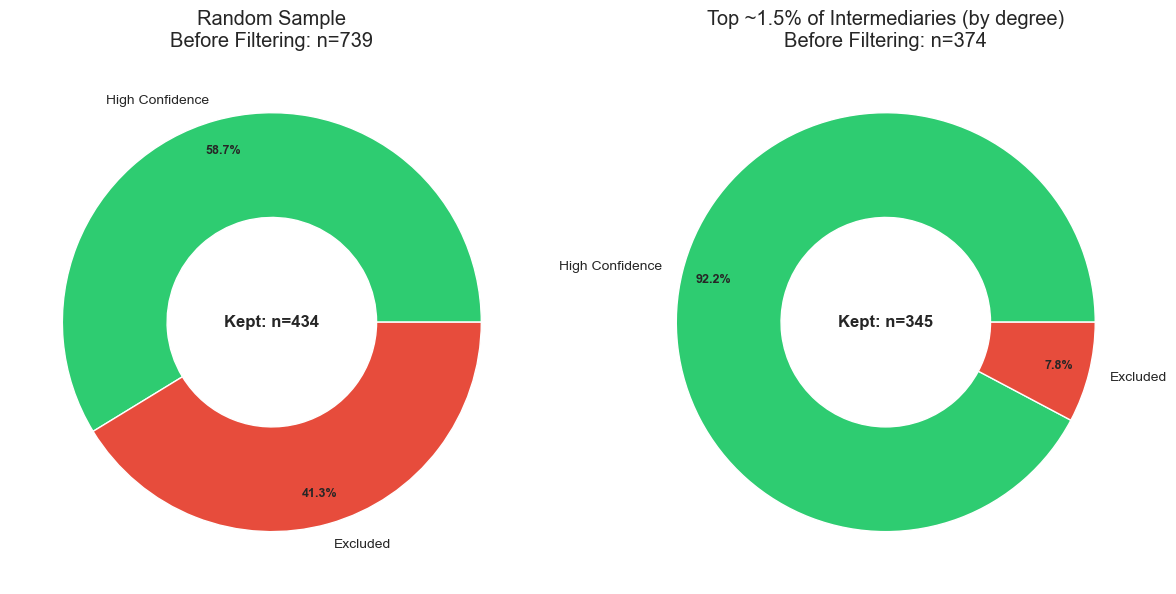

In [79]:
enriched_random_sample_500_path = Path("enrichment_data/enriched_random_sample_500.csv")
enriched_top_5_percent_intermediaries_path = Path("enrichment_data/enriched_top_5_percent_intermediaries.csv")

random_sample = pd.read_csv(enriched_random_sample_500_path)
top_5_percent = pd.read_csv(enriched_top_5_percent_intermediaries_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

def create_donut_chart(data, ax, title):
    total = len(data)
    filtered = len(data[
        (data["confidence"] == "High") & 
        (data["classification"] != "ERROR")
    ])
    
    wedges, texts, autotexts = ax.pie(
        [filtered, total - filtered],
        labels=['High Confidence', 'Excluded'],
        colors=['#2ecc71', '#e74c3c'],
        autopct='%1.1f%%',
        pctdistance=0.85,
        labeldistance=1.1,
        wedgeprops={'width': 0.5}
    )
    
    ax.set_title(f'{title}\nBefore Filtering: n={total:,}', pad=10)
    ax.text(0, 0, f'Kept: n={filtered:,}', 
            ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.setp(autotexts, size=9, weight="bold")
    plt.setp(texts, size=10)

create_donut_chart(random_sample, ax1, 'Random Sample')
create_donut_chart(top_5_percent, ax2, 'Top ~1.5% of Intermediaries (by degree)')

plt.tight_layout()
plt.savefig(PLOTS_PATH / 'Appendix_Filtering_of_Enrichment.png')

plt.show()

intermediaries_df_enriched_random_sample_500 = random_sample[
    (random_sample["confidence"] == "High") & 
    (random_sample["classification"] != "ERROR")
]
intermediaries_df_enriched_top_5_percent_intermediaries = top_5_percent[
    (top_5_percent["confidence"] == "High") & 
    (top_5_percent["classification"] != "ERROR")
]

In [50]:
intermediaries_df_enriched_top_5_percent_intermediaries["type"] = "Top 5% Intermediaries"
intermediaries_df_enriched_random_sample_500["type"] = "Random Sample"

intermediaries_df = intermediaries_df.merge(
    pd.concat([intermediaries_df_enriched_top_5_percent_intermediaries, intermediaries_df_enriched_random_sample_500]), on="name", how="left"
)
intermediaries_df.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count,regime_counts,regime_count,legal_tech_counts,legal_tech_count,bearers_connected,bearer_share,legal_tech_entropy,jurisdiction_entropy,regime_entropy,country_entropy,classification,confidence,role_muddled,role_muddled_reasoning,justification,is_individual,job_title,search_log,search_iterations,type
0,11000001,"MICHAEL PAPAGEORGE, MR.",ACTIVE,10001,MICHAEL PAPAGEORGE; MR. 106 NICHOLSON STREET B...,South Africa,ZAF,Panama Papers,The Panama Papers data is current through 2015,NaN,5.0,0.698970,{'ZAF': 5},1,{'BVI': 5},1,"{'Electoral Democracy': 4, 'Liberal Democracy'...",2,{},0,1.0,0.200000,0.0,0.000000,0.721928,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,CORFIDUCIA ANSTALT,ACTIVE,10004,NaN,Liechtenstein,LIE,Panama Papers,The Panama Papers data is current through 2015,NaN,10.0,1.000000,{'LIE': 10},1,"{'BVI': 4, 'PMA': 6}",2,{'Micro-state': 10},1,{},0,4.0,0.400000,0.0,0.970951,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,"DAVID, RONALD",SUSPENDED,10014,NaN,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'BVI': 1},1,{'Micro-state': 1},1,{},0,0.0,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000005,THE LEVANT LAWYERS (TLL),ACTIVE,10029,NaN,Lebanon,LBN,Panama Papers,The Panama Papers data is current through 2015,NaN,9.0,0.954243,{'LBN': 9},1,"{'BVI': 3, 'PMA': 6}",2,{'Electoral Autocracy': 9},1,{},0,7.0,0.777778,0.0,0.918296,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000006,"ABARTH, ANNELIESE",UNRECOVERABLE ACCOUNTS,1004,MS. ANNELIESE ABARTH 20 BOULEVARD PRINCESSE CH...,Monaco,MCO,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'MCO': 1},1,{'PMA': 1},1,{'Micro-state': 1},1,{},0,0.0,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Graphs of countries, jurisdictions and regimes serviced/servicing in

In [63]:
import networkx as nx

def create_intermediary_network(df, count_column):
    G = nx.Graph()
    for intermediary_idx, counts in enumerate(df[count_column]):
        locations = list(counts.keys())
        for i in range(len(locations)):
            for j in range(i + 1, len(locations)):
                loc1, loc2 = locations[i], locations[j]

                # Add nodes if they don't exist
                if not G.has_node(loc1):
                    G.add_node(loc1)
                if not G.has_node(loc2):
                    G.add_node(loc2)

                # Add or update edge weight
                if G.has_edge(loc1, loc2):
                    G[loc1][loc2]['weight'] += 1
                else:
                    G.add_edge(loc1, loc2, weight=1)
    return G

def get_node_stats(df, count_column):
    # Counting number of total appearances for each country
    node_appearances = {}

    for counts_dict in df[count_column]: 
        for node_key in counts_dict.keys():
            node_appearances[node_key] = node_appearances.get(node_key, 0) + 1
    
    return node_appearances

In [64]:
def filter_graph_for_visualization(
        G, node_appearances, total_intermediaries,
                                   max_nodes=50,
                                   min_node_appearance_count=1, 
                                   ):

    candidate_nodes = {
        node: count for node, count in node_appearances.items()
        if count >= min_node_appearance_count and node in G
    }

    sorted_nodes = sorted(candidate_nodes.keys(), key=lambda n: candidate_nodes[n], reverse=True)
    
    selected_nodes = set()
    if max_nodes > 0 and len(sorted_nodes) > 0:
        threshold_idx = min(max_nodes - 1, len(sorted_nodes) - 1)
        min_appearance_for_top_n = candidate_nodes[sorted_nodes[threshold_idx]]
        
        for node in sorted_nodes:
            if candidate_nodes[node] >= min_appearance_for_top_n:
                selected_nodes.add(node)
        
        if not selected_nodes and sorted_nodes : # if max_nodes was too small, or other edge cases
             selected_nodes = set(sorted_nodes[:max_nodes])


    else: # max_nodes <= 0 implies no limit by count, or no nodes to begin with
        selected_nodes = set(candidate_nodes.keys())

    G_sub = G.subgraph(selected_nodes).copy() # Create a subgraph with only these nodes and their induced edges
    return G_sub

def plot_network(G, title="Network Visualization", figsize=(12, 8),
                 edge_threshold_plot=0, layout_func=nx.spring_layout, cmap='viridis'):
    """Plot a network graph with customizable visualization parameters.
    
    Args:
        G: NetworkX graph object
        title: Plot title
        figsize: Figure size tuple
        node_size_multiplier: Multiplier for node sizes
        edge_threshold_plot: Minimum edge weight to display
        layout_func: Network layout function
        cmap: Color map for nodes
    """
    if G.number_of_nodes() == 0:
        print(f"Skipping network plot for {title}: No data to plot after filtering.")
        return None

    # Create a subgraph with only nodes that have edges
    nodes_with_edges = set()
    for u, v in G.edges():
        nodes_with_edges.add(u)
        nodes_with_edges.add(v)
    G = G.subgraph(nodes_with_edges)

    if G.number_of_nodes() == 0:
        print(f"Skipping network plot for {title}: No connected nodes after filtering.")
        return None

    plt.figure(figsize=figsize)
    
    # Use constant node size
    node_sizes = [600] * G.number_of_nodes()

    # Filter edges based on threshold
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edges_to_keep_plot = [(u, v) for (u, v), w in zip(G.edges(), edge_weights) if w > edge_threshold_plot]
    
    if not edges_to_keep_plot and G.edges(): 
        print(f"Warning for {title}: No edges meet plotting threshold {edge_threshold_plot}, but nodes will be drawn.")

    pos = layout_func(G) if G.number_of_nodes() > 0 else {}

    nx.draw_networkx_nodes(G, pos,
                          node_size=node_sizes,
                          node_color='grey',
                          alpha=0.8)
    
    if edges_to_keep_plot:
        weights_to_scale = [G[u][v]['weight'] for u,v in edges_to_keep_plot]
        if weights_to_scale:
            max_w = max(weights_to_scale)
            min_w = min(weights_to_scale)
            # Scale edge widths based on co-occurrence weights
            scaled_widths = ([1.0] * len(weights_to_scale) if max_w == min_w 
                           else [0.5 + (w - min_w) / (max_w - min_w) * 4.0 for w in weights_to_scale])
        else:
            scaled_widths = []

        nx.draw_networkx_edges(G, pos,
                               edgelist=edges_to_keep_plot,
                               width=scaled_widths,
                               alpha=0.4,
                               edge_color='grey')

    nx.draw_networkx_labels(G, pos, font_size=8 if G.number_of_nodes() < 50 else 6)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    return plt.gcf()



In [65]:
country_network_full = create_intermediary_network(intermediaries_df, 'country_counts')
jurisdiction_network_full = create_intermediary_network(intermediaries_df, 'jurisdiction_counts')
regime_network_full = create_intermediary_network(intermediaries_df, 'regime_counts')
legal_tech_network_full = create_intermediary_network(intermediaries_df, 'legal_tech_counts')

total_intermediaries = intermediaries_df.shape[0]

country_node_apps = get_node_stats(intermediaries_df, 'country_counts')
jurisdiction_node_apps = get_node_stats(intermediaries_df, 'jurisdiction_counts')
regime_node_apps = get_node_stats(intermediaries_df, 'regime_counts')
legal_tech_node_apps = get_node_stats(intermediaries_df, 'legal_tech_counts')

MAX_NODES_TO_SHOW = 20 
MIN_NODE_APPEARANCE = 50
MIN_EDGE_COOCCURRENCE = 50

MIN_LIFT_VALUE = 1.5 


# Country Network
country_network_filtered = filter_graph_for_visualization(
    country_network_full, country_node_apps, total_intermediaries,
    max_nodes=MAX_NODES_TO_SHOW,
    min_node_appearance_count=MIN_NODE_APPEARANCE,
    min_edge_weight=MIN_EDGE_COOCCURRENCE,
    min_lift=MIN_LIFT_VALUE
)

plot_network(country_network_filtered, title=f"Country Network (Filtered, Lift>{MIN_LIFT_VALUE})")
plt.show()

# Jurisdiction Network
jurisdiction_network_filtered = filter_graph_for_visualization(
    jurisdiction_network_full, jurisdiction_node_apps, total_intermediaries,
    max_nodes=MAX_NODES_TO_SHOW,
    min_node_appearance_count=MIN_NODE_APPEARANCE,
    min_edge_weight=MIN_EDGE_COOCCURRENCE,
    min_lift=MIN_LIFT_VALUE
)

plot_network(jurisdiction_network_filtered, title="Jurisdiction Network (Filtered)")
plt.show()


# Regime Network
regime_network_filtered = filter_graph_for_visualization(
    regime_network_full, regime_node_apps, regime_total_interm,
    max_nodes=10,      
    min_node_appearance_count=1,
    min_edge_weight=1, 
    min_lift=0 
)

plot_network(regime_network_filtered, title="Regime Network (Filtered)", cmap='plasma')
plt.show()

# Legal Tech Network

TypeError: filter_graph_for_visualization() got an unexpected keyword argument 'min_edge_weight'

# Preliminary and Overview Figures

## Timeline of Incorporations

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/551433151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entities_valid['incorporation_year'] = entities_valid['incorporation_year'].astype(int)


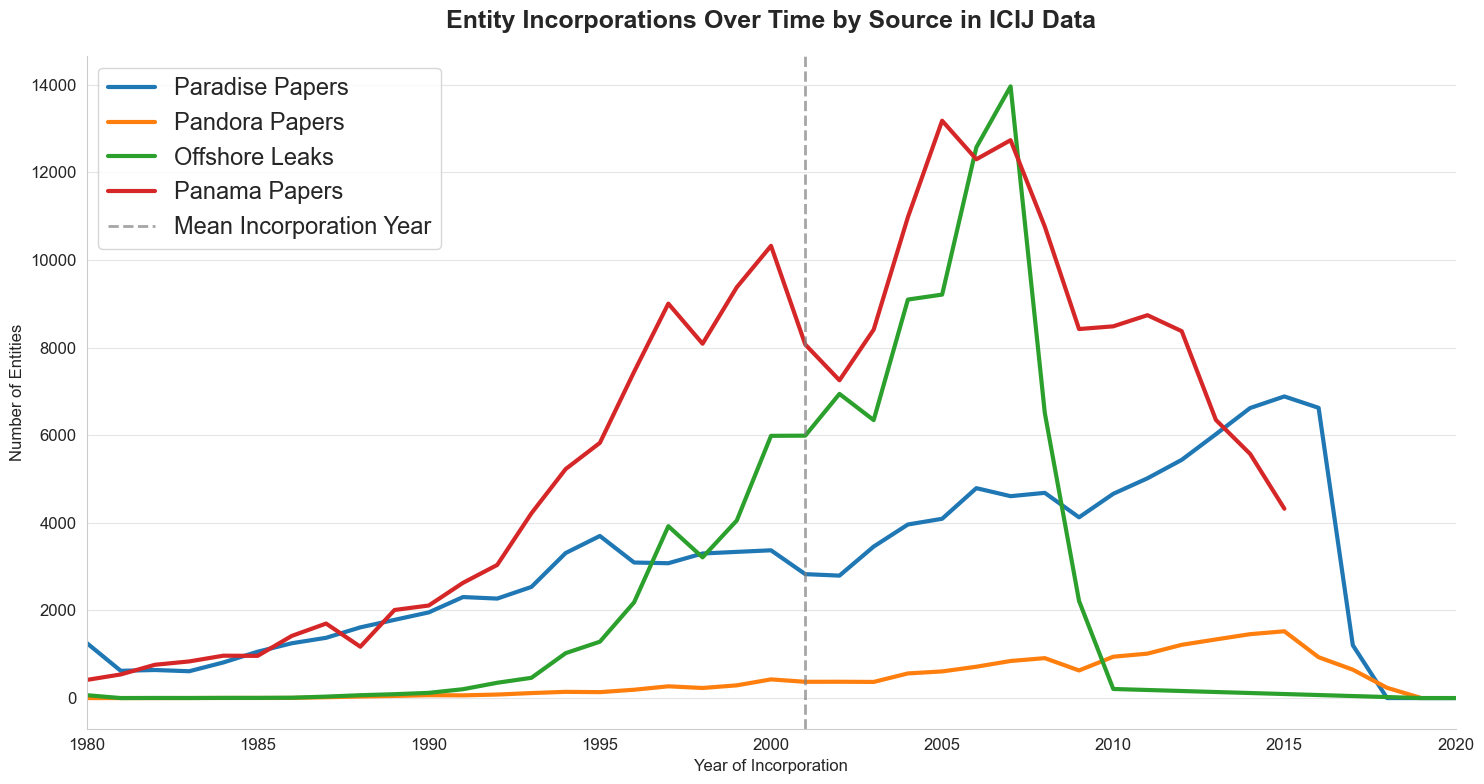

In [250]:
entities_df['incorporation_year'] = entities_df['incorporation_date'].dt.year
entities_valid = entities_df.dropna(subset=['incorporation_year', 'country_codes'])
entities_valid['incorporation_year'] = entities_valid['incorporation_year'].astype(int)

agg_counts = (
    entities_valid.groupby(['incorporation_year', 'source'])
    .size().reset_index(name='count')
)

plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='incorporation_year', y='count', data=agg_counts, hue='source', linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([1980, 2020])

plt.axvline(x=MEAN_INCORPORATION_YEAR, color='gray', linestyle='--', alpha=0.7, label="Mean Incorporation Year", linewidth=2)

plt.xlabel('Year of Incorporation', fontsize=12)
plt.ylabel('Number of Entities', fontsize=12)
plt.title('Entity Incorporations Over Time by Source in ICIJ Data', fontsize=18, pad=20, fontweight="bold")

plt.legend(loc='upper left', fontsize=17)

ax.yaxis.grid(True, linestyle='-', alpha=0.5)
ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig(PLOTS_PATH / "Preliminary_Incorporations_over_Time.png")

## Degree Distribution of Intermediaries:

* Show power-alw distribution fits well
* Use MLE to fit power law
* Goodness-of-fit using Kolmogorov-Smirnov statistics. ISSUE: assumes we know parameter a priori - not fitting it a posterriori like here with MLE. Recall Lillefors correction in the context of wehn we test against normal distributions. If this is what we want, this is the seminal paper:
* Clauset, A., Shalizi, C. R., & Newman, M. E. J. (2009). Power-law distributions in empirical data. SIAM Review, 51(4), 661-703. This paper provides a rigorous statistical framework for identifying and validating power-law distributions.
* An alternative to this is just comparing the fit of the power-law distribution to the fit of a log-normal distribution. 
* Note, we already have Kejriwal \& Dang (2020) showing this, so we can just use their results if need be



/opt/homebrew/anaconda3/lib/python3.12/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.



Power law fit results:
Alpha: 2.020
xmin: 1.000

Log likelihood ratio tests (R) and p-values:

Power law vs exponential:
R = 41159.768
p = 0.000
Power law is significantly better fit than exponential

Power law vs lognormal:
R = 3.878
p = 0.000
Power law is significantly better fit than lognormal


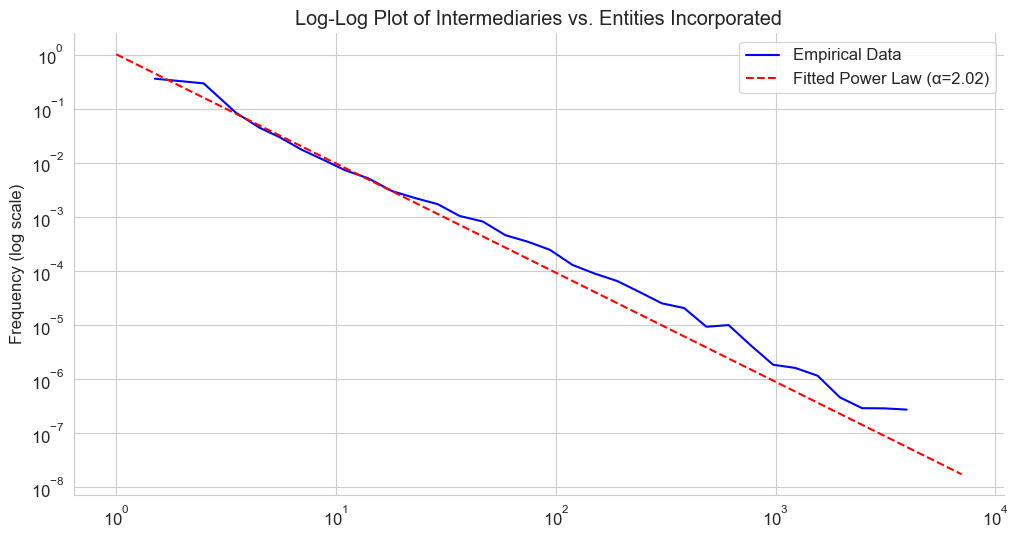

In [255]:
import powerlaw
import numpy as np


fit = powerlaw.Fit(intermediaries_df["degree"], xmin=1)

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()

fit.plot_pdf(color='b', label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Fitted Power Law (α={fit.alpha:.2f})')

plt.title('Log-Log Plot of Intermediaries vs. Entities Incorporated')
plt.ylabel('Frequency (log scale)')
plt.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

distributions = ['exponential', 'lognormal']
R, p = {}, {}
for dist in distributions:
    R[dist], p[dist] = fit.distribution_compare('power_law', dist)

print(f"\nPower law fit results:")
print(f"Alpha: {fit.alpha:.3f}")
print(f"xmin: {fit.xmin:.3f}")
print(f"\nLog likelihood ratio tests (R) and p-values:")
for dist in distributions:
    print(f"\nPower law vs {dist}:")
    print(f"R = {R[dist]:.3f}")
    print(f"p = {p[dist]:.3f}")
    if R[dist] > 0:
        if p[dist] < 0.05:
            print(f"Power law is significantly better fit than {dist}")
        else:
            print(f"Power law is better fit than {dist}, but not significantly")
    else:
        if p[dist] < 0.05:
            print(f"{dist} is significantly better fit than power law")
        else:
            print(f"{dist} is better fit than power law, but not significantly")

plt.show()

# Geographical Specialisation

## Which Countries are Intermediaries/Officers/Entities in?

Bar plots in 2x2 subplot across,
* Officers
* Intermediaries
* Entities (both countries they are active in, as well as the jurisdictions they are incorporated in)


/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/195615471.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_15_countries['percentage'] = (top_15_countries['count'] / total_count) * 100
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/195615471.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_15_countries['percentage'] = (top_15_countries['count'] / total_count) * 100
/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/195615471.py:73: SettingWithC

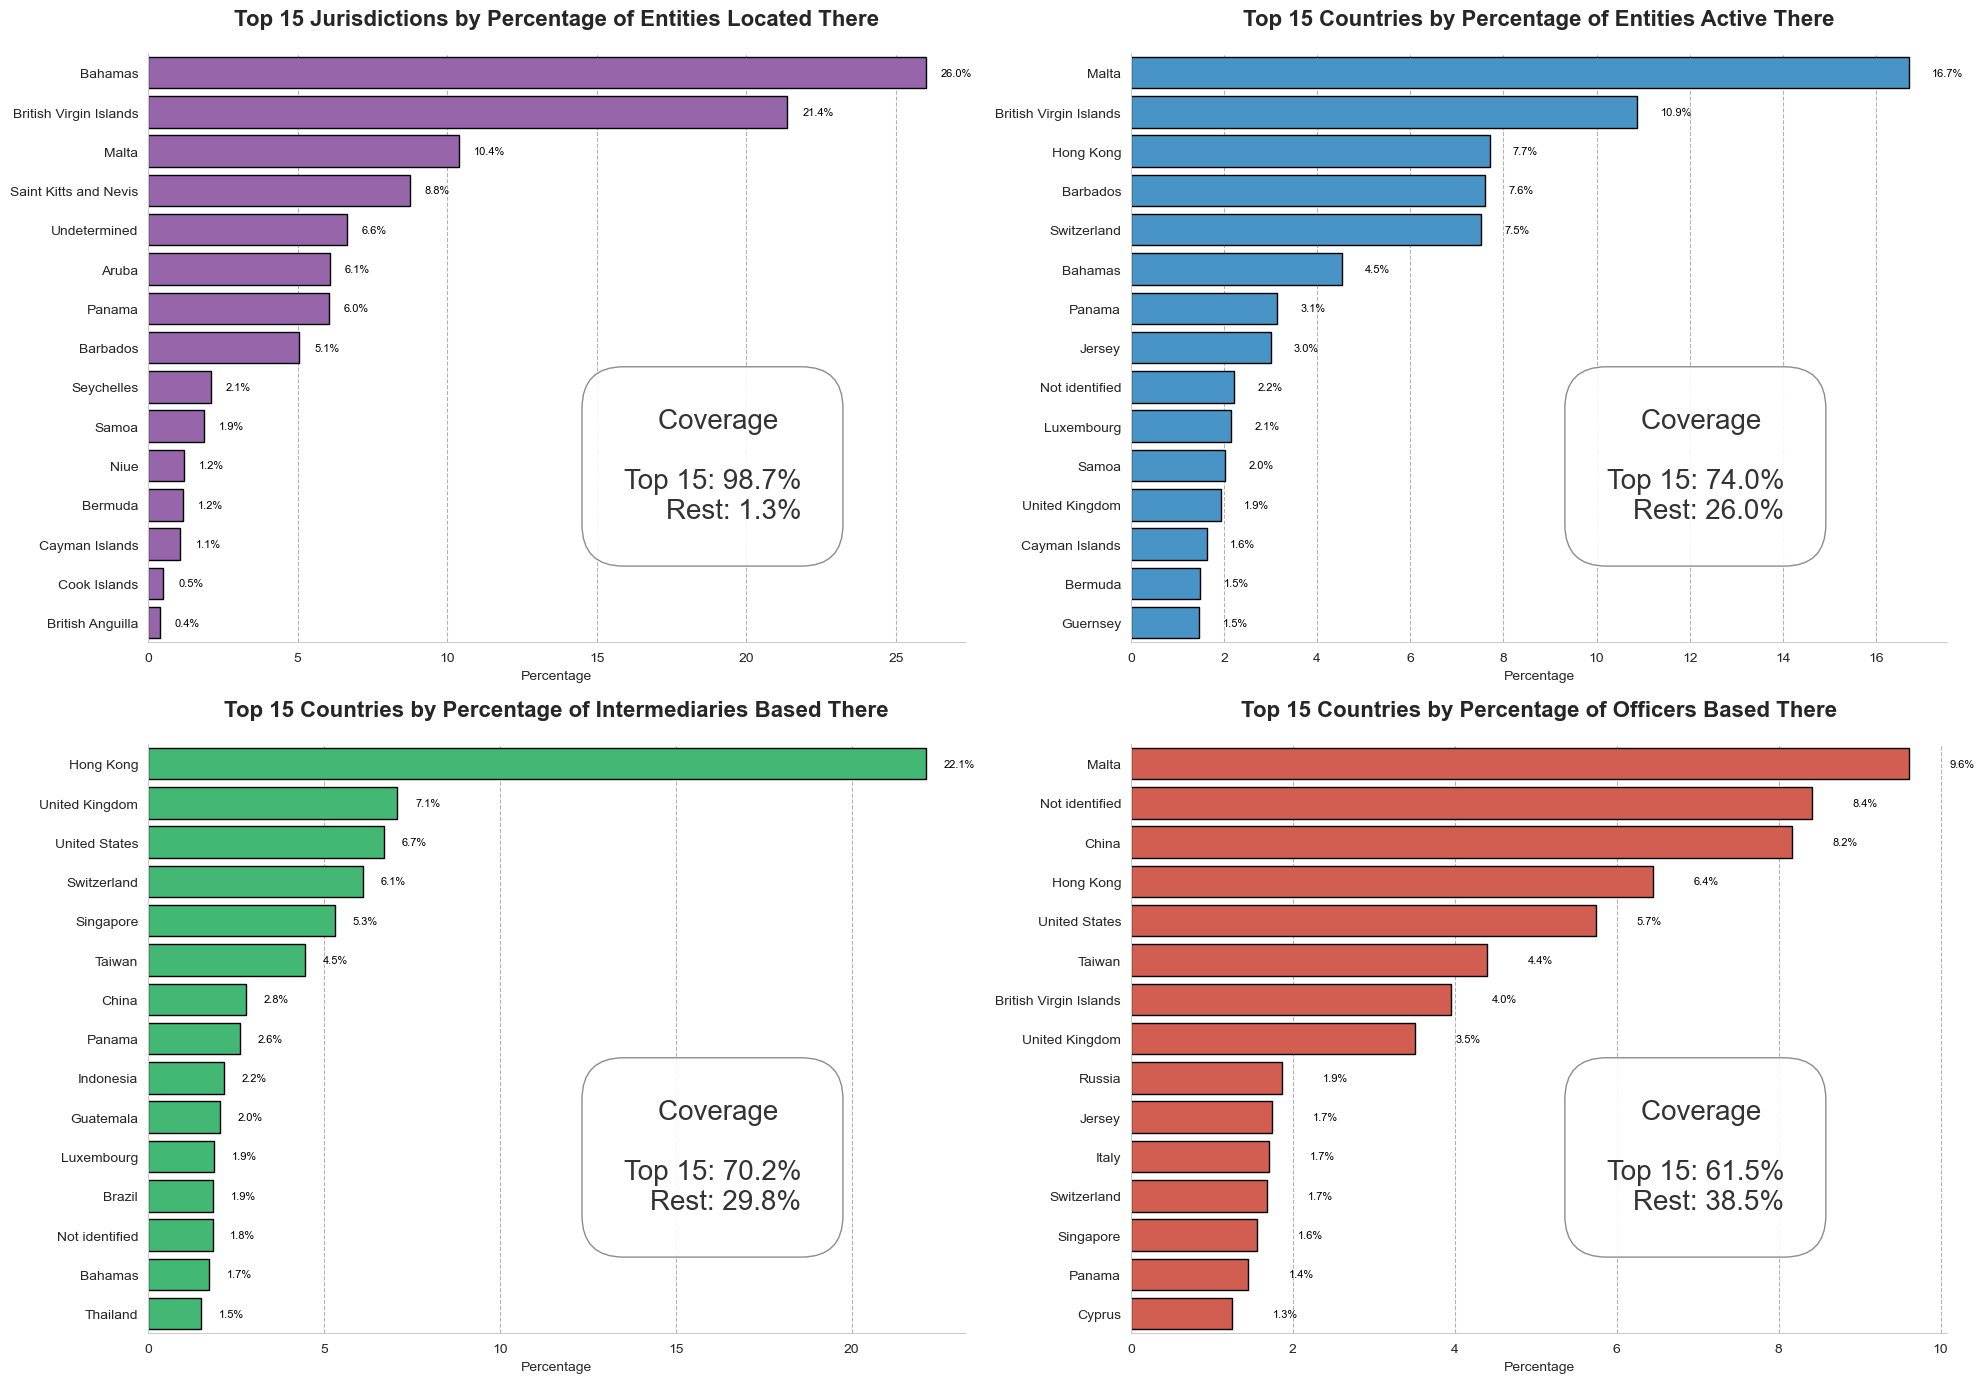

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

def create_barplot(ax, data, title, color, total_count):
    ax = sns.barplot(
        data=data,
        y='country',
        x='percentage',
        color=color,
        edgecolor='black',
        ax=ax
    )
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    
    for i, v in enumerate(data['percentage']):
        ax.text(v + 0.5, i, f'{v:.1f}%',
                ha='left', va='center', fontsize=8, color='black', fontweight='medium')
    
    ax.set_xlabel('Percentage', fontsize=10)
    ax.set_ylabel('')
    ax.grid(axis='x', linestyle='--', alpha=0.6, color='gray')
    sns.despine(ax=ax, trim=False)
    
    # Add coverage text
    top_15_percentage = (data['count'].sum() / total_count) * 100
    coverage_text = (
        f'Coverage   \n\n'
        f'Top 15: {top_15_percentage:.1f}%\n'
        f'Rest: {100-top_15_percentage:.1f}%'
    )
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray', pad=1.5)
    ax.text(0.80, 0.2, coverage_text,
            transform=ax.transAxes,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=props,
            fontsize=20,
            fontweight='medium',
            color='#333333')
    
    return ax

# Plot 1: Jurisdictions
country_counts = entities_df['jurisdiction_description'].dropna().value_counts().reset_index()
country_counts.columns = ['country', 'count']
top_15_countries = country_counts.head(15)
total_count = country_counts['count'].sum()
top_15_countries['percentage'] = (top_15_countries['count'] / total_count) * 100

ax1 = create_barplot(axes[0], top_15_countries, 
                    'Top 15 Jurisdictions by Percentage of Entities Located There',
                    '#9b59b6', total_count)

# Plot 2: Entity Countries
country_counts = entities_df['countries'].dropna().value_counts().reset_index()
country_counts.columns = ['country', 'count']
top_15_countries = country_counts.head(15)
total_count = country_counts['count'].sum()
top_15_countries['percentage'] = (top_15_countries['count'] / total_count) * 100

ax2 = create_barplot(axes[1], top_15_countries,
                    'Top 15 Countries by Percentage of Entities Active There',
                    '#3498db', total_count)

# Plot 3: Intermediary Countries
country_counts = intermediaries_df['countries'].dropna().value_counts().reset_index()
country_counts.columns = ['country', 'count']
top_15_countries = country_counts.head(15)
total_count = country_counts['count'].sum()
top_15_countries['percentage'] = (top_15_countries['count'] / total_count) * 100

ax3 = create_barplot(axes[2], top_15_countries,
                    'Top 15 Countries by Percentage of Intermediaries Based There',
                    '#2ecc71', total_count)

# Plot 4: Officer Countries
country_counts = officers_df['countries'].dropna().value_counts().reset_index()
country_counts.columns = ['country', 'count']
top_15_countries = country_counts.head(15)
total_count = country_counts['count'].sum()
top_15_countries['percentage'] = (top_15_countries['count'] / total_count) * 100

ax4 = create_barplot(axes[3], top_15_countries,
                    'Top 15 Countries by Percentage of Officers Based There',
                    '#e74c3c', total_count)


plt.tight_layout()
plt.savefig(PLOTS_PATH / "Geography_Overview.png", dpi=300)
plt.show()

## How many Countries do Intermediaries Incorporate Entities in And Which?
* Distribution of the number of countries they incorporate in

Transition: Doesn't account for the fact that some just incorporate more!
* Distirbution of entropy scores

Transition: Groups of countries they incorporate in

Graph of the countries they incorporate in approach: 
* Edge weight increases, if an intermediary incorporates in ocuntries in common. E.g. if he has entities in Singapore and Hong kong they are proivded one more to their weight.
* When visualising, only showing edge to reduce space from about ~125 countries according to rule of some minimum lift OR Cooccurrence threshold (E.g. minimum lift of 1.5 or minimum cooccurence of 10%)
a. Colouring in according to regime type
b. Colouring in according to louvain community detection
* Reporting highest in-betweenness scores 
* Reporting associations with highest lift scores + Fisher exact test to confirm statistical significance

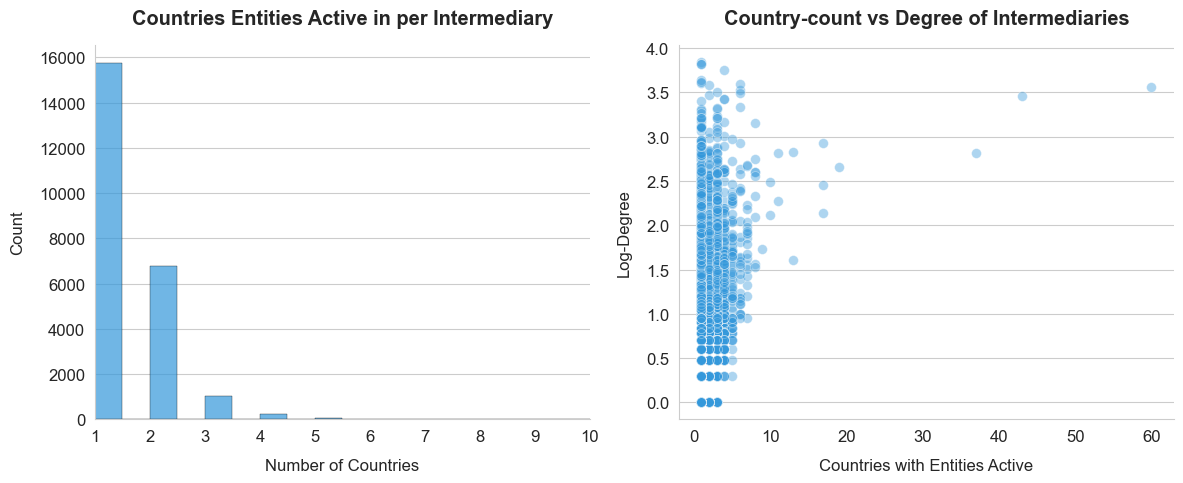

In [254]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Distribution of Countries per Intermediary
sns.histplot(data=intermediaries_df, x='country_count', ax=ax1, 
             color='#3498db', alpha=0.7, edgecolor='black', binwidth=0.5)
ax1.set_xlabel('Number of Countries', labelpad=10)
ax1.set_xlim(1, 10)
ax1.set_ylabel('Count', labelpad=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

y = intermediaries_df['country_count'].value_counts().sort_index()
ax1.grid(axis='x')
ax1.set_title('Countries Entities Active in per Intermediary', pad=15, weight='bold')

# Relationship between Countries and Network Degree
sns.scatterplot(data=intermediaries_df, x='country_count', y='log_degree', 
                ax=ax2, alpha=0.4, color='#3498db', s=50)
ax2.set_xlabel('Countries with Entities Active', labelpad=10)
ax2.set_ylabel('Log-Degree', labelpad=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x')
ax2.set_title('Country-count vs Degree of Intermediaries', pad=15, weight='bold')

plt.tight_layout()
plt.savefig(PLOTS_PATH / "Geography_Distribution_of_Countries_by_Intermediary.png")
plt.show()

## Which Jurisidctions do they Incorporate in?
* Power-law distribution of how many they incorporate
* Distribution of the number of jurisdictions they incorporate in

Same transition:
* Distirbution of entropy scores

Same approach as above with the jurisdictions they incorporate in.
* EXCEPT: Colouring in according to legal technology types
* Reporting highest in-betweenness scores
* Reporting associations with highest lift scores + Fisher exact test to confirm statistical significance

## What are the most common intermediary-country to entity-country/jurisdiction pair? Cyprus and Singapore case studies
* Bipartite graph too difficult to visualise, so 
* we just show the distribution of two countries: Cyprean intermediaries and Singaporean, for example
* And Heatmap of 15 or so biggest entities by cooccurence (e.g. row sums to 1)

# Functional Specialisation

## Differences in Entropies + Bearer Shares
Looking across the different types of entropy scores and the share of entities whom use bearer instruments.
HOW TO TEST SIGNIFICANCE HERE?
 

/var/folders/zd/clvkhmk53z5_z0q5fj9zmtvm0000gn/T/ipykernel_72321/2723602426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_sample['bearer_dummy'] = (random_sample['bearer_share'] > 0).astype(int)


<Figure size 1500x800 with 0 Axes>

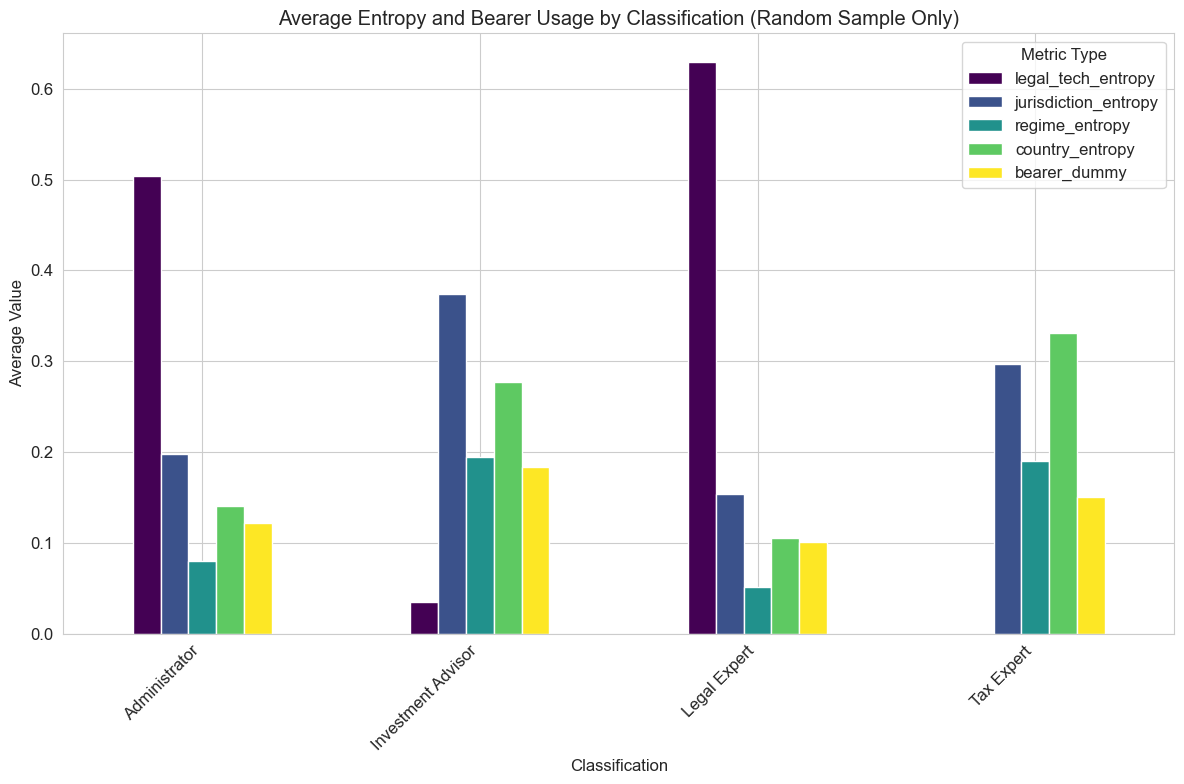


Mann-Whitney U Test Results:
--------------------------------------------------

LEGAL_TECH_ENTROPY:
------------------------------
Investment Advisor vs Legal Expert:
U-statistic: 5088.00
p-value: 0.0000
Significant: Yes

Investment Advisor vs Administrator:
U-statistic: 8143.50
p-value: 0.0000
Significant: Yes

Investment Advisor vs Tax Expert:
U-statistic: 900.00
p-value: 0.4097
Significant: No

Legal Expert vs Administrator:
U-statistic: 57501.50
p-value: 0.0012
Significant: Yes

Legal Expert vs Tax Expert:
U-statistic: 4710.00
p-value: 0.0000
Significant: Yes

Administrator vs Tax Expert:
U-statistic: 5310.00
p-value: 0.0000
Significant: Yes


JURISDICTION_ENTROPY:
------------------------------
Investment Advisor vs Legal Expert:
U-statistic: 15872.00
p-value: 0.0000
Significant: Yes

Investment Advisor vs Administrator:
U-statistic: 18524.50
p-value: 0.0002
Significant: Yes

Investment Advisor vs Tax Expert:
U-statistic: 915.50
p-value: 0.6923
Significant: No

Legal Expert vs A

In [173]:
random_sample = intermediaries_df[intermediaries_df['type'] == 'Random Sample']

# Create bearer dummy (1 if bearer_share > 0, 0 otherwise)
random_sample['bearer_dummy'] = (random_sample['bearer_share'] > 0).astype(int)

# Calculate means for entropy metrics and bearer dummy
entropy_means = random_sample.groupby('classification')[['legal_tech_entropy', 'jurisdiction_entropy', 'regime_entropy', 'country_entropy', 'bearer_dummy']].mean()

plt.figure(figsize=(15, 8))
entropy_means[['legal_tech_entropy', 'jurisdiction_entropy', 'regime_entropy', 'country_entropy', 'bearer_dummy']].plot(
    kind='bar',
    stacked=False,
    colormap='viridis'
)
plt.title('Average Entropy and Bearer Usage by Classification (Random Sample Only)')
plt.xlabel('Classification')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric Type')
plt.tight_layout()
plt.show()

# Perform Mann-Whitney U tests for each metric
from scipy.stats import mannwhitneyu

metrics = ['legal_tech_entropy', 'jurisdiction_entropy', 'regime_entropy', 'country_entropy', 'bearer_dummy']
classifications = random_sample['classification'].unique()

print("\nMann-Whitney U Test Results:")
print("-" * 50)

for metric in metrics:
    print(f"\n{metric.upper()}:")
    print("-" * 30)
    
    # Compare each pair of classifications
    for i, class1 in enumerate(classifications):
        for class2 in classifications[i+1:]:
            group1 = random_sample[random_sample['classification'] == class1][metric]
            group2 = random_sample[random_sample['classification'] == class2][metric]
            
            # Perform Mann-Whitney U test
            stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
            
            print(f"{class1} vs {class2}:")
            print(f"U-statistic: {stat:.2f}")
            print(f"p-value: {pval:.4f}")
            print(f"Significant: {'Yes' if pval < 0.05 else 'No'}")
            print()


## Differences in Degrees:
* CDF of the different types showing it.
* Comparison of random smaple vs. the the ones in the top 500 - e.g. administrators the ones that have an incredibly high degree, whereas we tax experts and legal experts more personal advisory. Not connected to as many.
* Testing signifianace of degree differences using Negative Binomial random component + natural logarithm as the link function?




Degree Statistics by Classification:

nan:
Count: 0
Mean: nan
Median: nan
Std Dev: nan
Min: nan
Max: nan

Administrator:
Count: 353
Mean: 20.88
Median: 1.00
Std Dev: 155.90
Min: 1
Max: 2671

Investment Advisor:
Count: 87
Mean: 12.34
Median: 2.00
Std Dev: 26.57
Min: 1
Max: 124

Legal Expert:
Count: 289
Mean: 4.23
Median: 1.00
Std Dev: 17.86
Min: 1
Max: 230

Tax Expert:
Count: 20
Mean: 28.85
Median: 6.00
Std Dev: 47.42
Min: 1
Max: 194


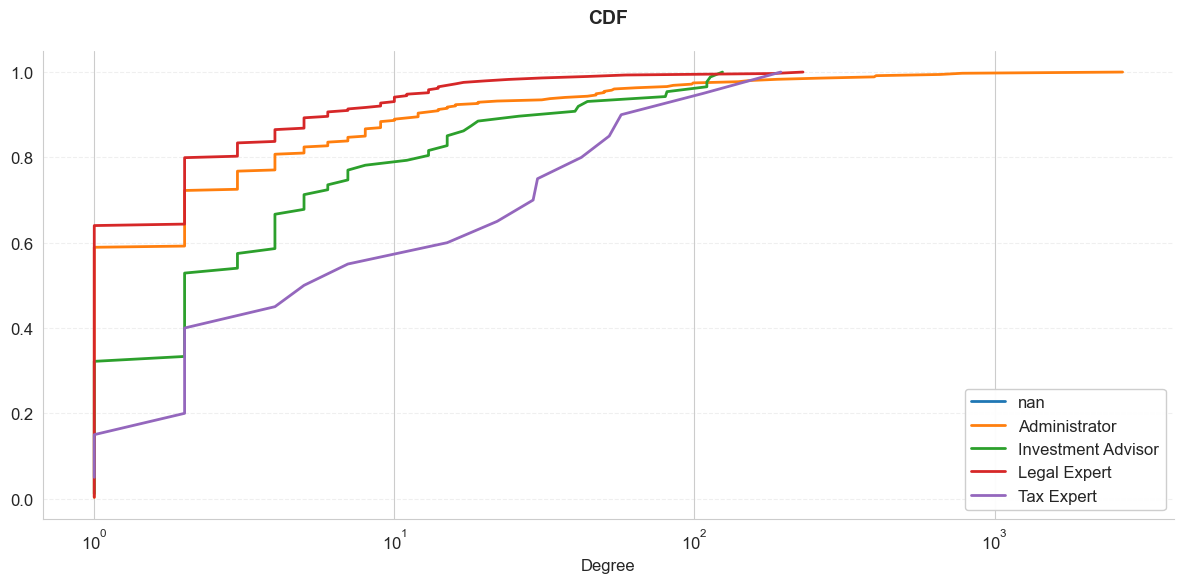

In [230]:
# CDF
fig, ax = plt.subplots(figsize=(12, 6))

classifications = intermediaries_df['classification'].unique()
random_sample = intermediaries_df[intermediaries_df["type"] == "Random Sample"]

print("\nDegree Statistics by Classification:")
for classification in classifications:
    mask = random_sample['classification'] == classification
    degrees = random_sample[mask]['degree']
    
    stats = degrees.describe()
    print(f"\n{classification}:")
    print(f"Count: {stats['count']:.0f}")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Median: {stats['50%']:.2f}")
    print(f"Std Dev: {stats['std']:.2f}")
    print(f"Min: {stats['min']:.0f}")
    print(f"Max: {stats['max']:.0f}")
    
    sorted_degrees = np.sort(degrees)
    cdf = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    ax.plot(sorted_degrees, cdf, label=classification, linewidth=2)

# Clean up the plot
ax.set_title('CDF', pad=20, fontsize=14, fontweight='bold')
ax.set_xlabel('Degree', fontsize=12)
ax.set_xscale('log')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Clean up legend
ax.legend(frameon=True, framealpha=0.95)

plt.tight_layout()
plt.show()

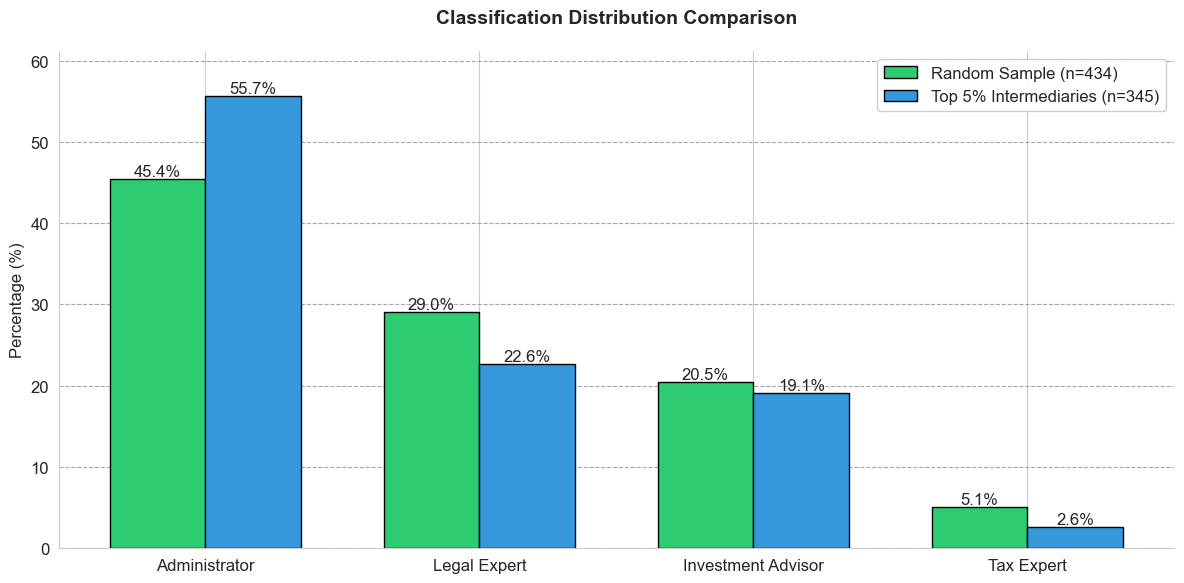

In [67]:
# Comparison of random sample vs. ones in top 500
random_sample_data = intermediaries_df_enriched_random_sample_500['classification'].value_counts(normalize=True).mul(100)
top_5_percent_data = intermediaries_df_enriched_top_5_percent_intermediaries['classification'].value_counts(normalize=True).mul(100)

plt.figure(figsize=(12, 6))

x = np.arange(len(random_sample_data))
width = 0.35

for i, classification in enumerate(random_sample_data.index):
    plt.bar(x[i] - width/2, random_sample_data[classification], width, 
            label=f'Random Sample (n={len(intermediaries_df_enriched_random_sample_500)})' if i == 0 else "", 
            color='#2ecc71', edgecolor='black')
    plt.bar(x[i] + width/2, top_5_percent_data[classification], width, 
            label=f'Top 5% Intermediaries (n={len(intermediaries_df_enriched_top_5_percent_intermediaries)})' if i == 0 else "", 
            color='#3498db', edgecolor='black')
    
    plt.text(x[i] - width/2, random_sample_data[classification], 
             f'{random_sample_data[classification]:.1f}%', 
             ha='center', va='bottom')
    plt.text(x[i] + width/2, top_5_percent_data[classification], 
             f'{top_5_percent_data[classification]:.1f}%', 
             ha='center', va='bottom')

plt.title('Classification Distribution Comparison', pad=20, fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(x, random_sample_data.index, rotation=0)
plt.legend(frameon=True, framealpha=0.95)

plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.margins(y=0.1)

plt.tight_layout()
plt.show()

## Clustering different intermediaries and seeing if they cluster by type
Idea: Though wit hthat many countries and jurisdictions we'd end up with a super sparse matrix, we can do some feature selection exactly by virtue of the fact that countries and officers are so tightly located. We have this long dataframe in this case, with dictionary objects flattened out as columns, which we then proceed to try to cluster then doing some pca/t-sne/mds to visualise in 2-dimensions



## Case studies of one of each type (in the appendix)
having the case study of each of those revealed into the appendix


In [228]:
random_sample = intermediaries_df[intermediaries_df["type"] == "Random Sample"]
stratified_sample = pd.concat([
    random_sample[random_sample['classification'] == 'Administrator'].sample(n=1, random_state=42),
    random_sample[random_sample['classification'] == 'Investment Advisor'].sample(n=1, random_state=42),
    random_sample[random_sample['classification'] == 'Legal Expert'].sample(n=1, random_state=42),
    random_sample[random_sample['classification'] == 'Tax Expert'].sample(n=1, random_state=42)
])

stratified_sample.head()

,node_id,name,status,internal_id,address,countries,country_codes,sourceID,valid_until,note,degree,log_degree,country_counts,country_count,jurisdiction_counts,jurisdiction_count,regime_counts,regime_count,legal_tech_counts,legal_tech_count,bearers_connected,bearer_share,legal_tech_entropy,jurisdiction_entropy,regime_entropy,country_entropy,classification,confidence,role_muddled,role_muddled_reasoning,justification,is_individual,job_title,search_log,search_iterations,type
23113,135087494,BOURQUE MARY ELLEN M.,NaN,NaN,NaN,NaN,NaN,Paradise Papers - Barbados corporate registry,Barbados corporate registry data is current th...,NaN,1.0,0.000000,{'BRB': 1},1,{'BRB': 1},1,{'Micro-state': 1},1,"{'Banking': 1, 'IBC': 1, 'Insurance': 1, 'Ship...",5,0.0,0.000000,1.0,0.000000,0.0,0.000000,Administrator,High,False,The role appears to be clearly related to admi...,The search results indicate that Mary Ellen M....,True,Unknown,"[{'iteration': 0, 'query': 'BOURQUE MARY ELLEN...",3.0,Random Sample
20821,294709,Platinum Management Services Limited,NaN,NaN,NaN,Hong Kong,HKG,Offshore Leaks,The Offshore Leaks data is current through 2010,NaN,13.0,1.113943,"{'HKG': 1, 'VGB': 9, 'XXX': 3}",3,"{'BVI': 9, 'HK': 3, 'XXX': 1}",3,{'Micro-state': 13},1,{},0,4.0,0.307692,0.0,0.719333,0.0,0.719333,Investment Advisor,High,False,NaN,Platinum Financial Services Limited (PFS) is a...,False,Unknown,"[{'iteration': 0, 'query': 'Platinum Managemen...",3.0,Random Sample
7790,11007839,MAITRE MAYA OBEGI,ACTIVE,32845,NaN,United Kingdom,GBR,Panama Papers,The Panama Papers data is current through 2015,NaN,1.0,0.000000,{'LBN': 1},1,{'BVI': 1},1,{'Electoral Autocracy': 1},1,{},0,1.0,1.000000,0.0,0.000000,0.0,0.000000,Legal Expert,High,False,NaN,The title 'Maitre' suggests a legal profession...,True,Lawyer,"[{'iteration': 0, 'query': 'MAITRE MAYA OBEGI'...",3.0,Random Sample
361,11000366,MARTIN & DAVIDOFF,ACTIVE,10404,NaN,Switzerland,CHE,Panama Papers,The Panama Papers data is current through 2015,NaN,29.0,1.462398,{'CHE': 29},1,"{'BAH': 1, 'BVI': 11, 'NIUE': 7, 'PMA': 10}",4,{'Liberal Democracy': 29},1,{},0,10.0,0.344828,0.0,0.861326,0.0,0.000000,Tax Expert,High,False,The role is clearly defined as a tax expert.,The search results indicate that MARTIN & DAVI...,False,Tax Attorney and CPA Firm,"[{'iteration': 0, 'query': 'MARTIN & DAVIDOFF'...",3.0,Random Sample


Note: XXX just means that country could not be identified from the documents that ICIJ had in their possession

Administrator: Bourque Mary Ellen M.. Through Primex, a liability-limiting organisation for companies specialising within some sort of chemistry. Under this one of the service providers they note is Bourque Mary Ellen M. associated with `The Corporate Secretary Limited` listed as the primary contact perosn. Firm based in Barbados.
(Likewise, we can confirm this from a filing found from the SEC with incorporation documents as the LLM has done)
Note: LLM confuses it a bit. Thinks she's directly associated with Primex Ltd.
Don't have infomration on where she's based (though the llm has found it's Barbados - but not in ICIJ which is the source we use for htis information)
Incorporating in Barbados, and this seems to be her primary responsibility to help from offshore to do this)
Entirely concentrated in Barbados, and the one incorproation she has is also here.


Investment Advisor: Platinum Management Services Limited.
Hong-kong based Insureance Broker Company, providing financial advice.
13 entities connected to it. 
Mostly clients from British Virgin Islands, one from Hong Kong and 3 unknown ones 
Incorporating mostyl in British Virgin Isalnd as wel, as well as Hong Kong. Notably, none of them have any particular legal technologies


Legal Expert: Maitre Maya Obegi
Dicey classification.... Because of the name with Maitre fro lawyers in french-speaking countries, consistent with client in Lebanon, but no concrete sources on it.
Client in Lebanon
Incorporating in British Virgin Islands
Autocratic country, and we see there's some bearer instruments connected to hwat she did there.
(Funny enough ICIJ classifies country as United Kingdom as where she's based. Probably.)

And the officers connected to that entity: One officer from Bahrain, that's a shareholder and that one bearer instrument


Tax Expert: Martin & Davidoff
Tax attorney and general CPA firm.
Clients exclusively from swtizerland. 
Incorporating in Bahamas, British virgin Islands, Niue and Panama -> high jursidiction entropy of 0.86
A lot of bearer instruments... 10 of the 29